In [2]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [8]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('jan29list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['TSN','JD']
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2017-12-14'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [4]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [5]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df, etf

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2007-01-09  17.820000      0.050000     0.002810   0.011941          0.212794   
2007-01-08  17.860001      0.040001     0.002242   0.011780          0.210387   
2007-01-05  17.639999     -0.220002    -0.012395   0.013939          0.245883   
2007-01-04  17.680000      0.040001     0.002265   0.007421          0.131212   
2007-01-03  17.510000     -0.170000    -0.009662   0.007749          0.135686   

            price_dev  annual_vol  
Date                               
2007-01-09   0.178117    0.189562  
2007-01-08   0.187980    0.186998  
2007-01-05  -1.045701    0.221274  
2007-01-04   0.162683    0.117812  
2007-01-03  -1.295618    0.123012  
---------------------
Date of largest drop
-7.79606126872
2008-04-17 00:00:00
---------------------
Date of largest spike
4.94894681012
2008-09-05 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


3.5371642927402811

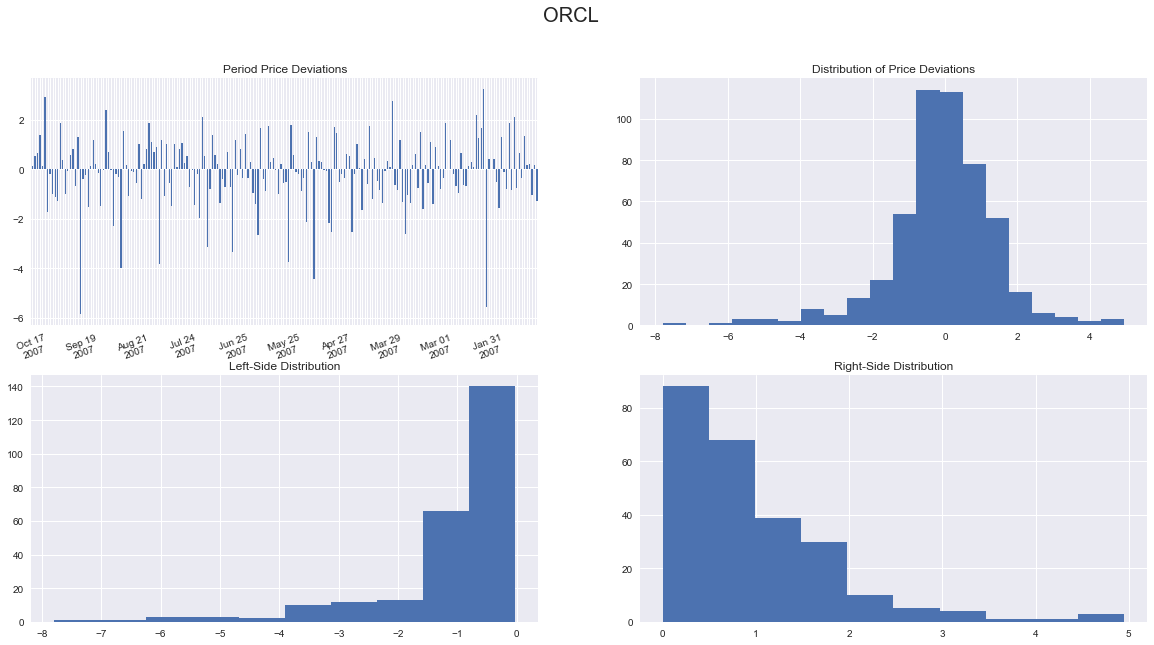

In [13]:
rolling_period = 4
lookback_window = 200
hist_window = 500
ticker = 'ORCL'
summary, full_df = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)
full_df['price_dev'].dropna().skew()

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-19    6.44         -0.11    -0.016937   0.030804          0.198379   
2018-01-22    6.22         -0.22    -0.034759   0.034587          0.215133   
2018-01-23    6.30          0.08     0.012780   0.019639          0.123727   
2018-01-24    6.28         -0.02    -0.003180   0.020211          0.126924   
2018-01-25    6.29          0.01     0.001591   0.020374          0.128151   

            price_dev  annual_vol  
Date                               
2018-01-19  -0.442903    0.489001  
2018-01-22  -1.108989    0.549057  
2018-01-23   0.371862    0.311762  
2018-01-24  -0.161647    0.320838  
2018-01-25   0.078787    0.323423  
---------------------
Date of largest drop
-10.1898702725
2017-10-31 00:00:00
---------------------
Date of largest spike
9.1637478536
2016-11-09 00:00:00
---------------------
                prices  

C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-01-19  85.489998     -0.330002    -0.003853   0.012394          1.059589   
2018-01-22  85.440002     -0.049996    -0.000585   0.007073          0.604317   
2018-01-23  84.419998     -1.020004    -0.012010   0.004828          0.407572   
2018-01-24  84.300003     -0.119995    -0.001422   0.005216          0.439695   
2018-01-25  85.010002      0.709999     0.008387   0.008347          0.709590   

            price_dev  annual_vol  
Date                               
2018-01-19  -0.282450    0.196753  
2018-01-22  -0.047184    0.112280  
2018-01-23  -1.687864    0.076641  
2018-01-24  -0.294415    0.082799  
2018-01-25   1.614752    0.132507  
---------------------
Date of largest drop
-10.2643125164
2016-11-23 00:00:00
---------------------
Date of largest spike
11.0494639501
2016-06-29 00:00:00
---------------------
  

               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-01-19  71.889999      0.400001     0.005580   0.011982          0.861382   
2018-01-22  73.160004      1.270005     0.017512   0.011455          0.838042   
2018-01-23  73.120003     -0.040001    -0.000547   0.010377          0.758737   
2018-01-24  71.589996     -1.530007    -0.021147   0.016174          1.157888   
2018-01-25  71.080002     -0.509994    -0.007149   0.016054          1.141089   

            price_dev  annual_vol  
Date                               
2018-01-19   0.393476    0.190208  
2018-01-22   1.474380    0.181841  
2018-01-23  -0.047732    0.164723  
2018-01-24  -2.016518    0.256752  
2018-01-25  -0.440452    0.254843  
---------------------
Date of largest drop
-6.50555852499
2016-04-29 00:00:00
---------------------
Date of largest spike
16.2085054079
2016-11-21 00:00:00
---------------------
  

C:\Users\Fang\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


                prices  prices_delta  log_returns  daily_vol  \
Date                                                           
2018-01-19  366.049988      0.799988     0.002188   0.010721   
2018-01-22  370.250000      4.200012     0.011409   0.007574   
2018-01-23  369.250000     -1.000000    -0.002705   0.010264   
2018-01-24  376.179993      6.929993     0.018594   0.009498   
2018-01-25  375.140015     -1.039978    -0.002768   0.010653   

            daily_vol_dollar  price_dev  annual_vol  
Date                                                 
2018-01-19          3.924418   0.180630    0.170190  
2018-01-22          2.804371   1.070225    0.120238  
2018-01-23          3.789959  -0.356586    0.162935  
2018-01-24          3.572949   1.828514    0.150776  
2018-01-25          3.996255  -0.291070    0.169106  
---------------------
Date of largest drop
-9.2873942171
2016-10-11 00:00:00
---------------------
Date of largest spike
17.5652035113
2017-01-26 00:00:00
------------------

            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-19  13.590         0.000     0.000000   0.001470          0.019971   
2018-01-22  13.570        -0.020    -0.001473   0.001407          0.019096   
2018-01-23  13.590         0.020     0.001473   0.001899          0.025805   
2018-01-24  13.560        -0.030    -0.002210   0.001633          0.022145   
2018-01-25  13.505        -0.055    -0.004064   0.002302          0.031090   

            price_dev  annual_vol  
Date                               
2018-01-19   0.000000    0.023328  
2018-01-22  -1.001471    0.022339  
2018-01-23   1.047333    0.030143  
2018-01-24  -1.162576    0.025924  
2018-01-25  -2.483671    0.036545  
---------------------
Date of largest drop
-8.87281230247
2016-08-02 00:00:00
---------------------
Date of largest spike
5.79843416707
2017-08-14 00:00:00
---------------------
            prices  pri

            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-19  13.590         0.000     0.000000   0.001470          0.019971   
2018-01-22  13.570        -0.020    -0.001473   0.001407          0.019096   
2018-01-23  13.590         0.020     0.001473   0.001899          0.025805   
2018-01-24  13.560        -0.030    -0.002210   0.001633          0.022145   
2018-01-25  13.505        -0.055    -0.004064   0.002302          0.031090   

            price_dev  annual_vol  
Date                               
2018-01-19   0.000000    0.023328  
2018-01-22  -1.001471    0.022339  
2018-01-23   1.047333    0.030143  
2018-01-24  -1.162576    0.025924  
2018-01-25  -2.483671    0.036545  
---------------------
Date of largest drop
-8.87281230247
2016-08-02 00:00:00
---------------------
Date of largest spike
5.79843416707
2017-08-14 00:00:00
---------------------
            prices  pri

            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-19  13.590         0.000     0.000000   0.001470          0.019971   
2018-01-22  13.570        -0.020    -0.001473   0.001407          0.019096   
2018-01-23  13.590         0.020     0.001473   0.001899          0.025805   
2018-01-24  13.560        -0.030    -0.002210   0.001633          0.022145   
2018-01-25  13.505        -0.055    -0.004064   0.002302          0.031090   

            price_dev  annual_vol  
Date                               
2018-01-19   0.000000    0.023328  
2018-01-22  -1.001471    0.022339  
2018-01-23   1.047333    0.030143  
2018-01-24  -1.162576    0.025924  
2018-01-25  -2.483671    0.036545  
---------------------
Date of largest drop
-8.87281230247
2016-08-02 00:00:00
---------------------
Date of largest spike
5.79843416707
2017-08-14 00:00:00
---------------------
            prices  pri

            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-19  13.590         0.000     0.000000   0.001470          0.019971   
2018-01-22  13.570        -0.020    -0.001473   0.001407          0.019096   
2018-01-23  13.590         0.020     0.001473   0.001899          0.025805   
2018-01-24  13.560        -0.030    -0.002210   0.001633          0.022145   
2018-01-25  13.505        -0.055    -0.004064   0.002302          0.031090   

            price_dev  annual_vol  
Date                               
2018-01-19   0.000000    0.023328  
2018-01-22  -1.001471    0.022339  
2018-01-23   1.047333    0.030143  
2018-01-24  -1.162576    0.025924  
2018-01-25  -2.483671    0.036545  
---------------------
Date of largest drop
-8.87281230247
2016-08-02 00:00:00
---------------------
Date of largest spike
5.79843416707
2017-08-14 00:00:00
---------------------
            prices  pri

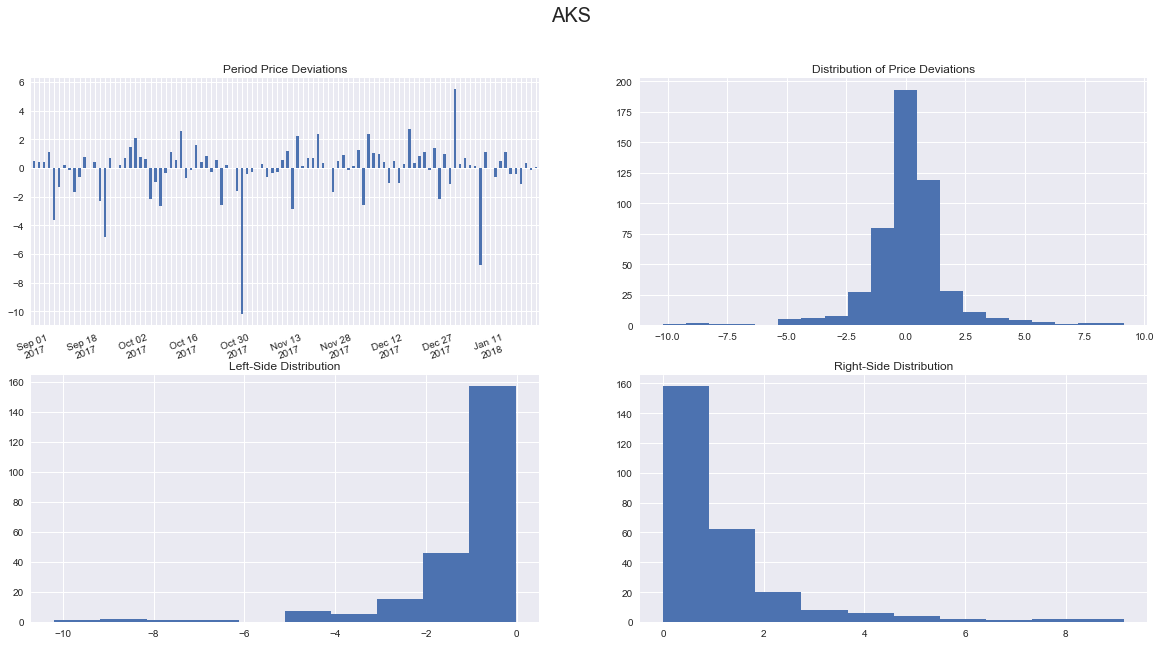

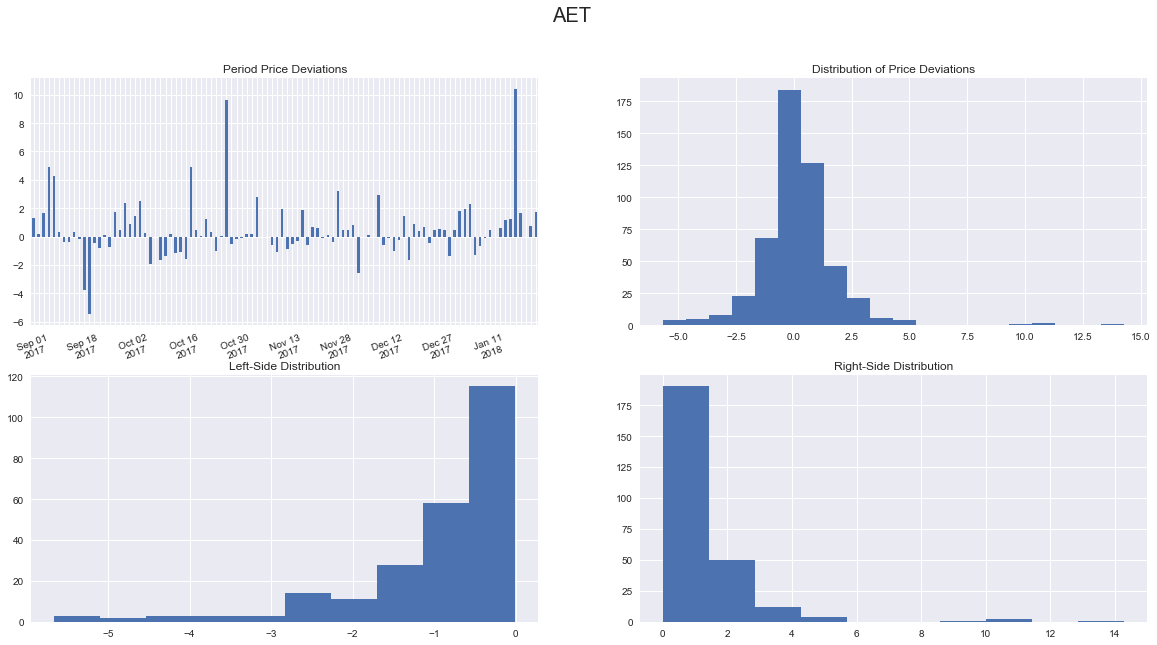

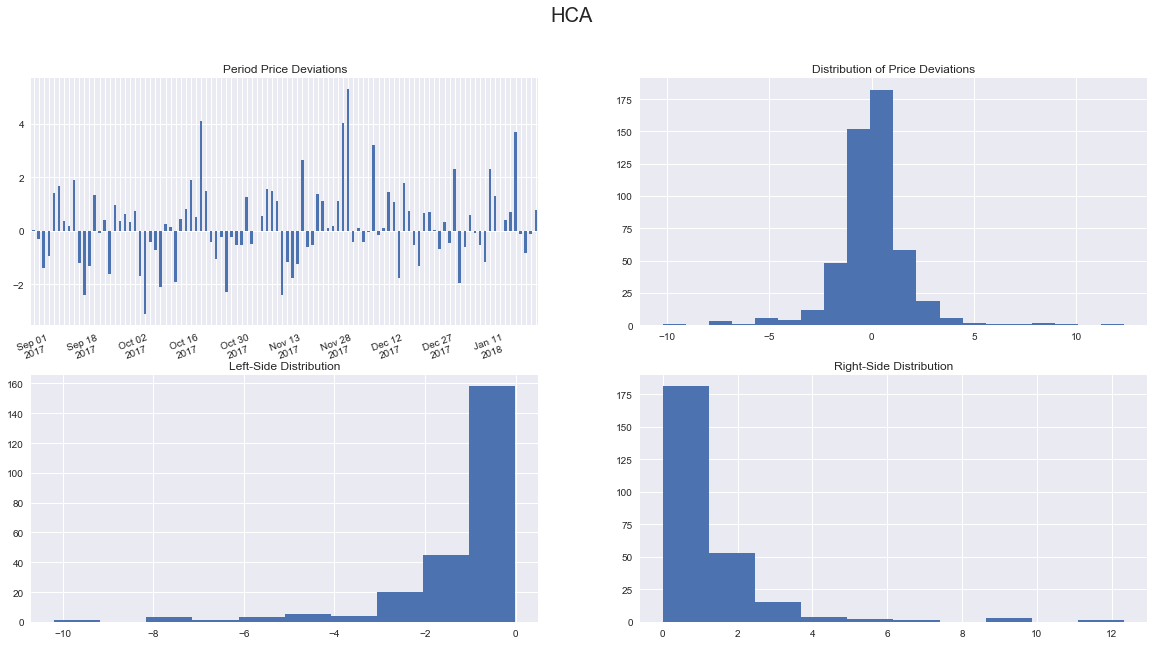

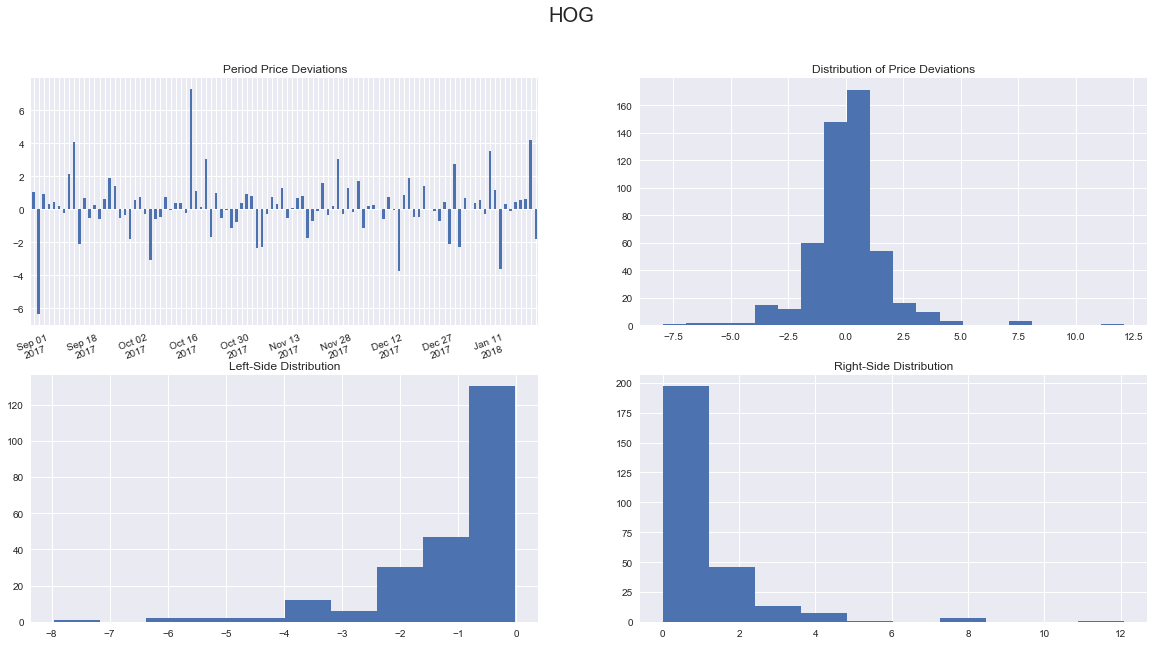

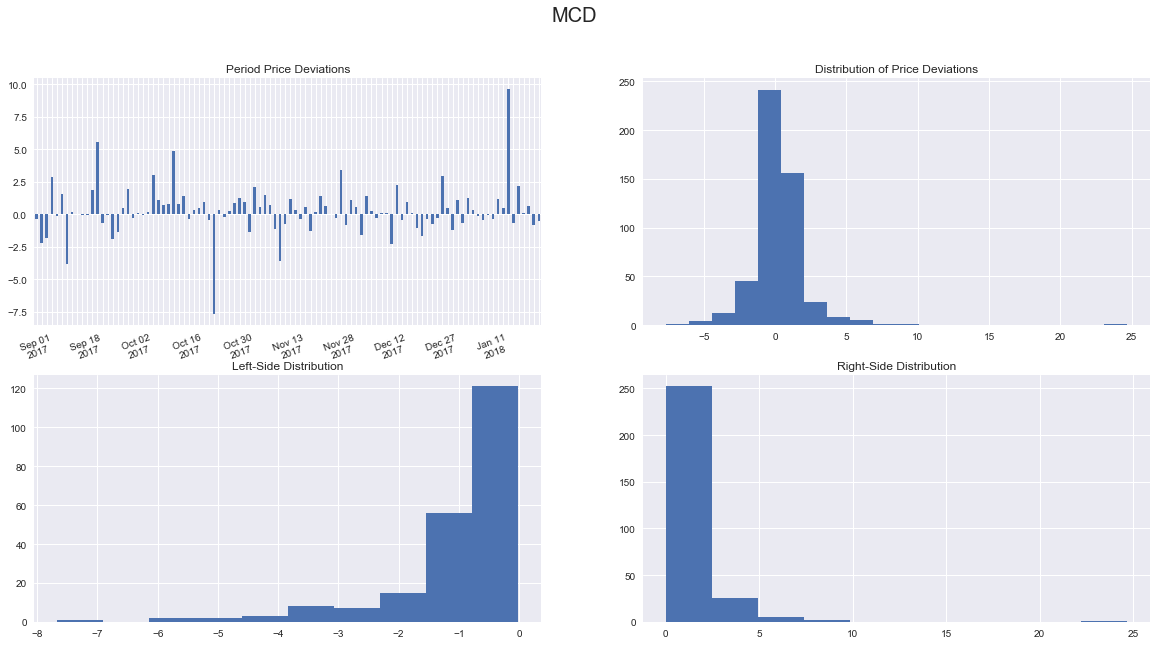

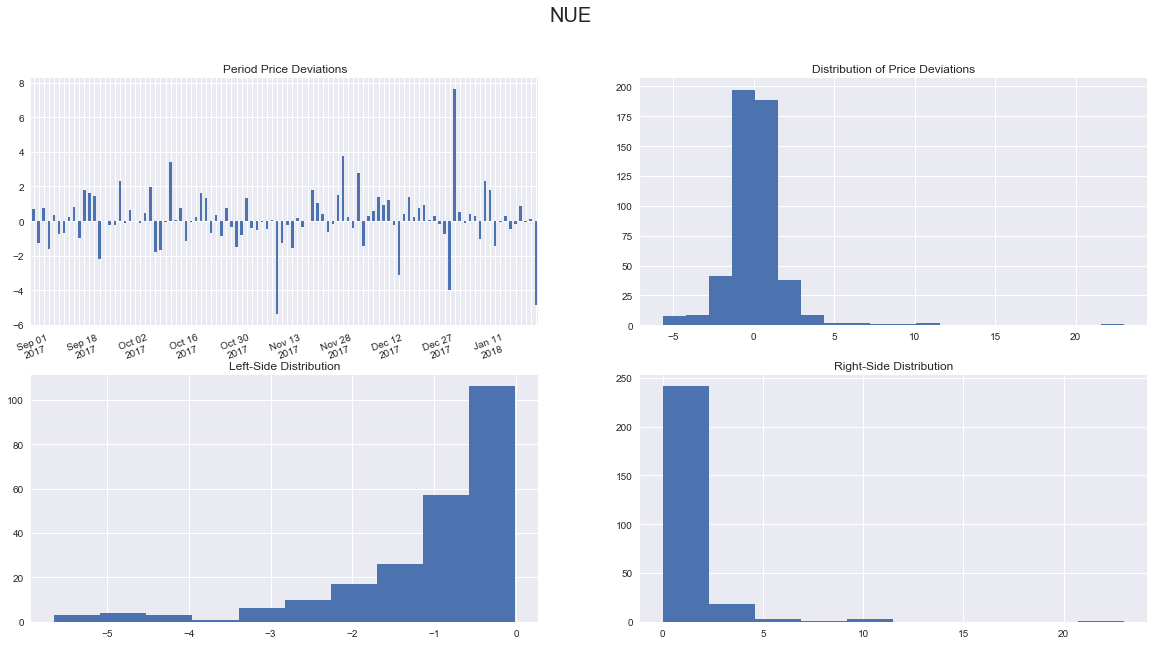

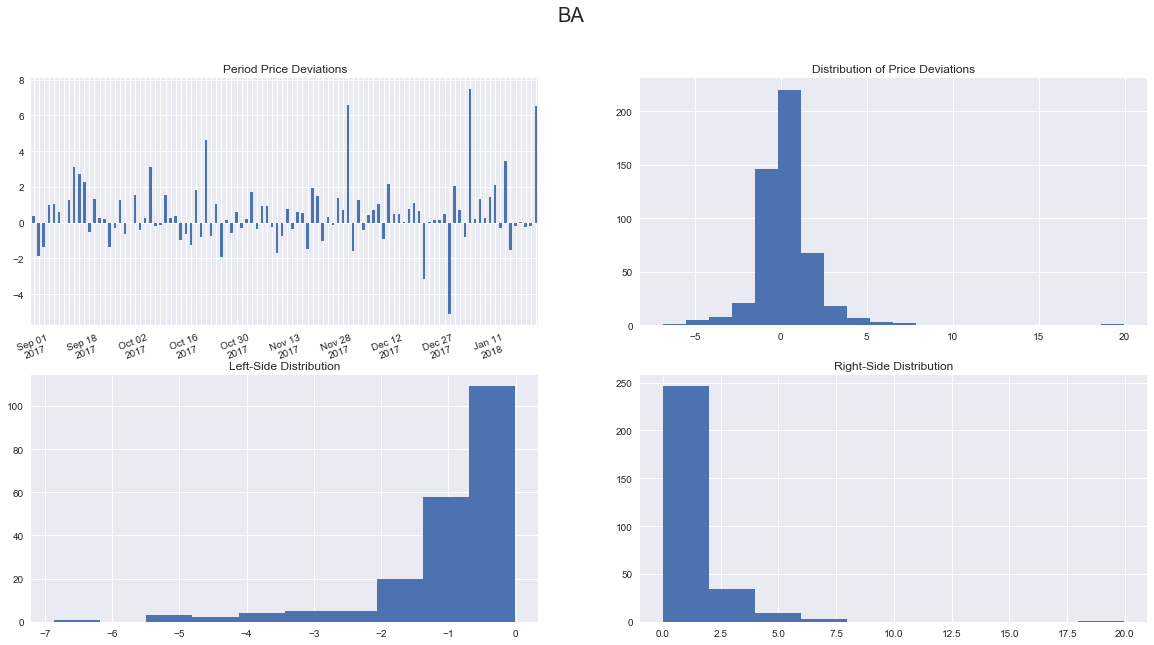

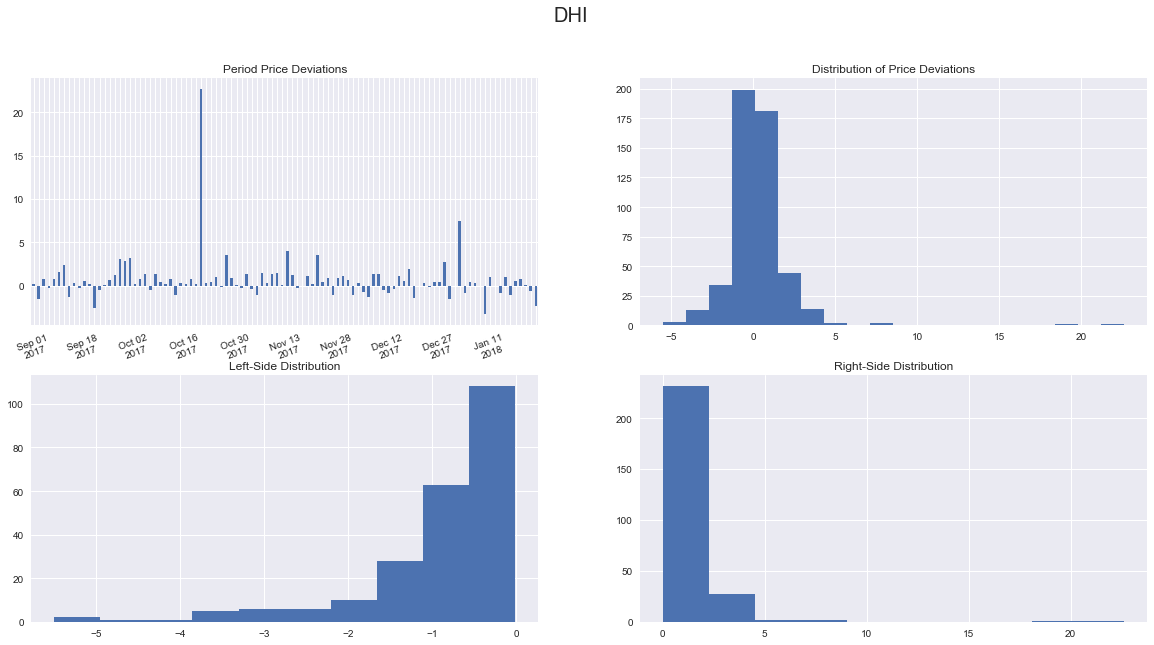

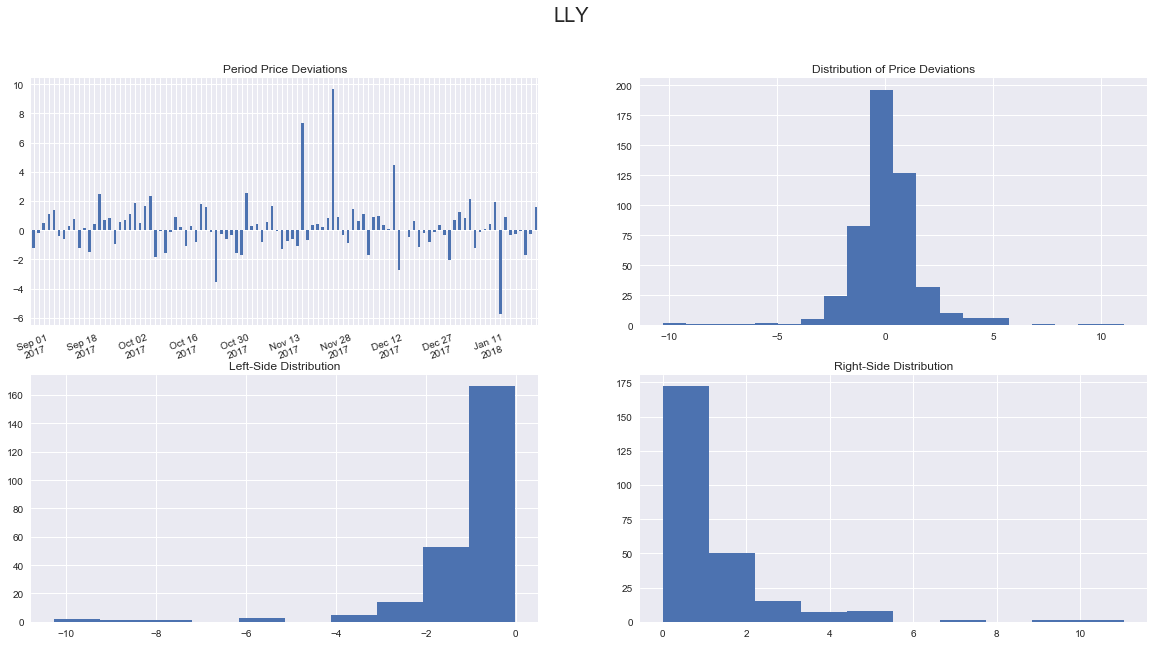

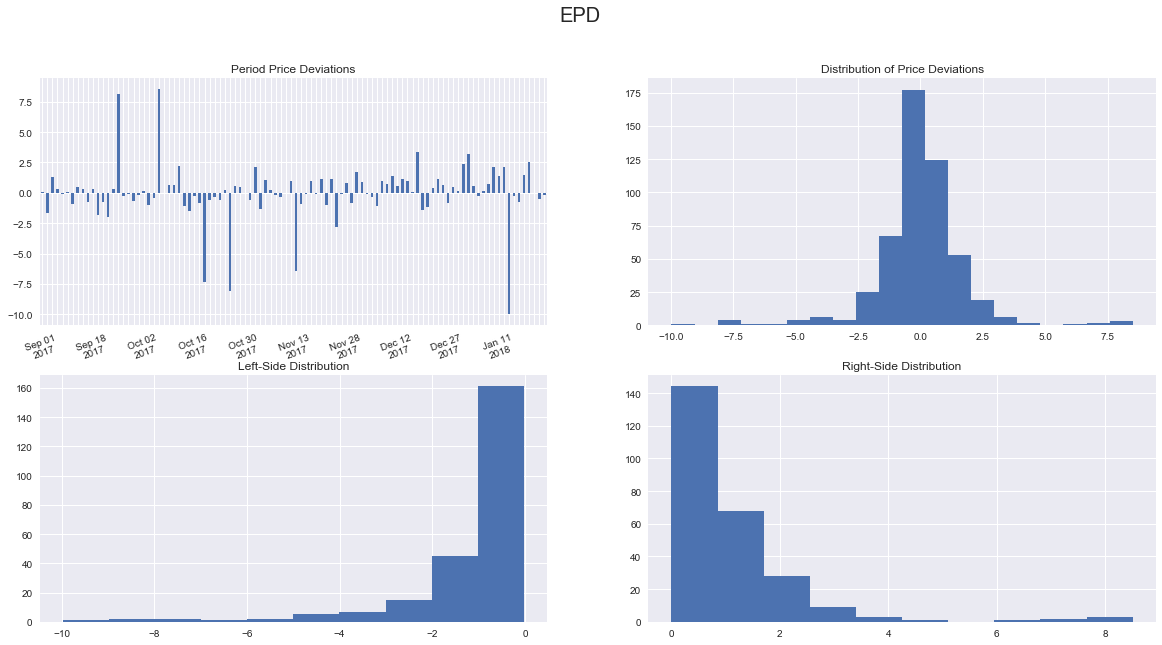

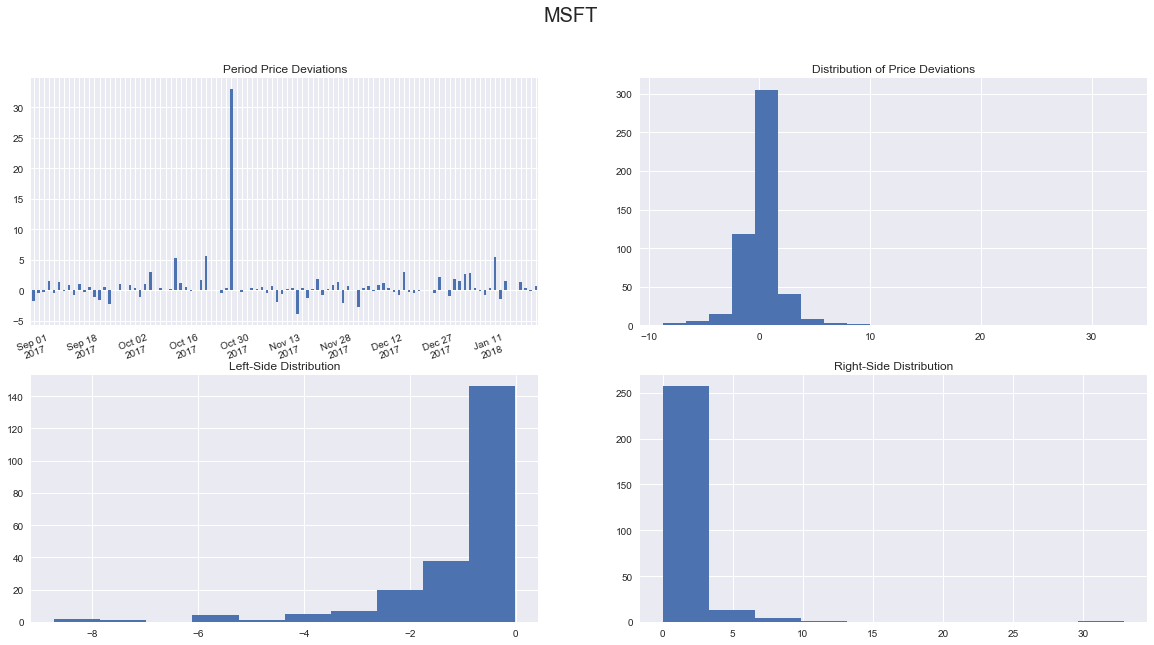

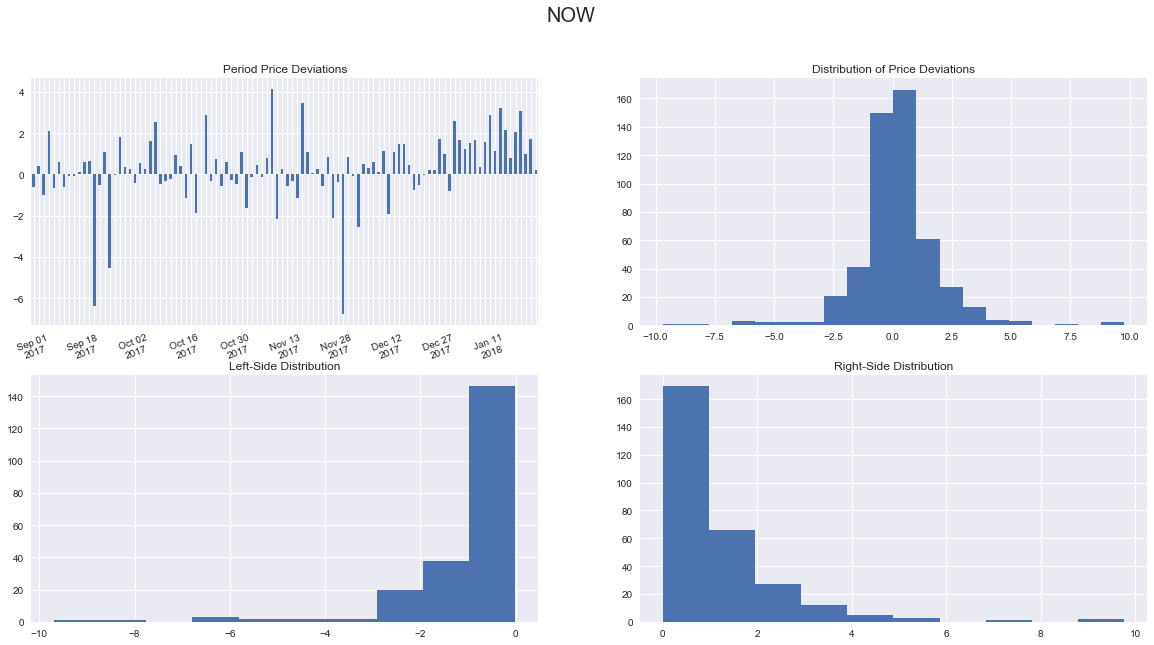

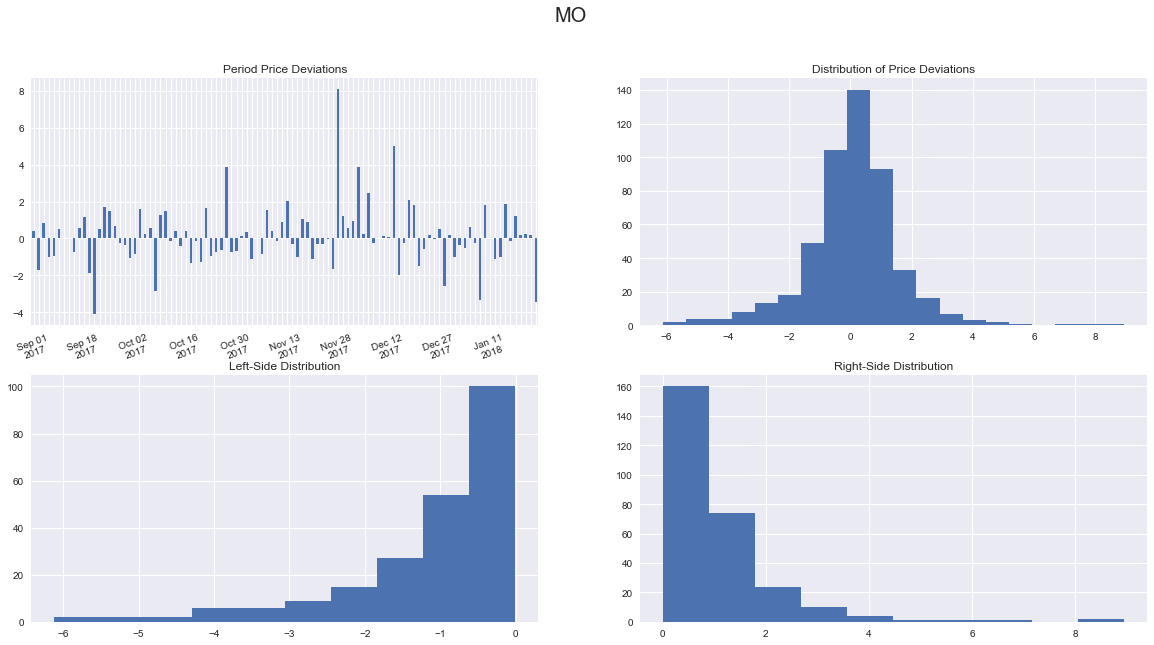

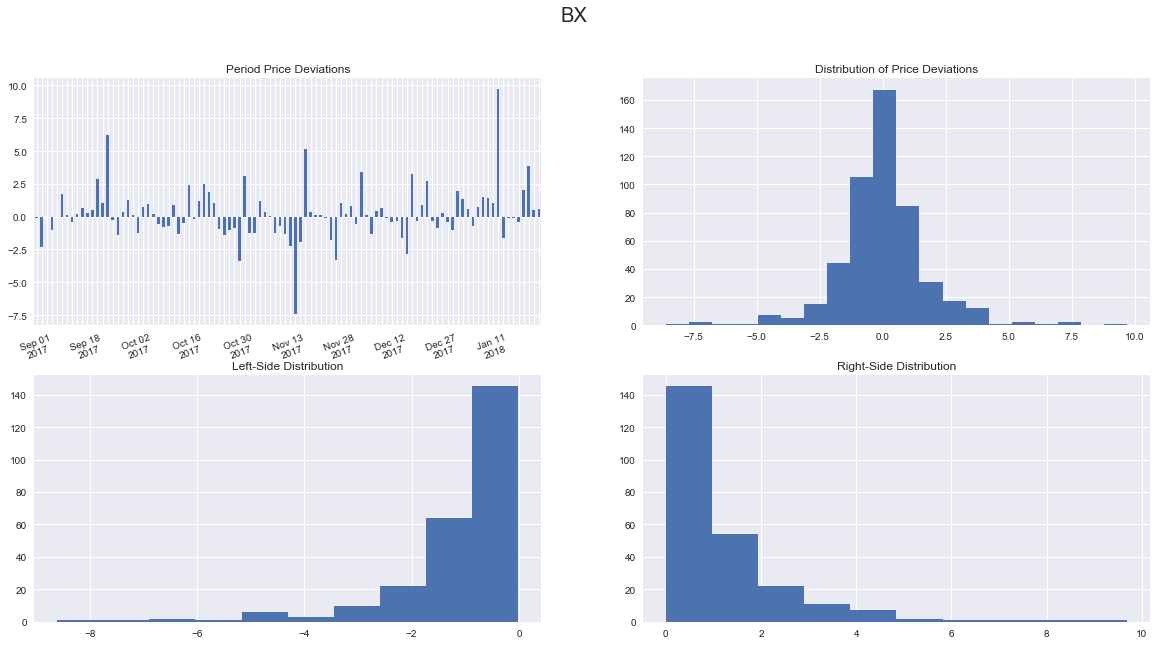

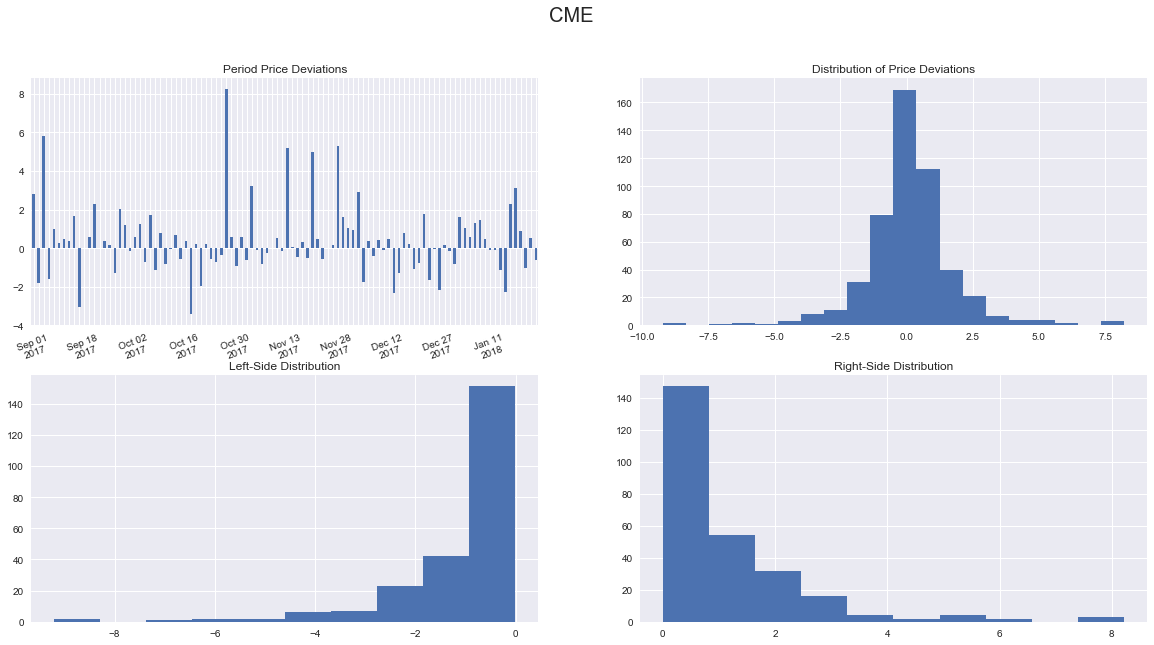

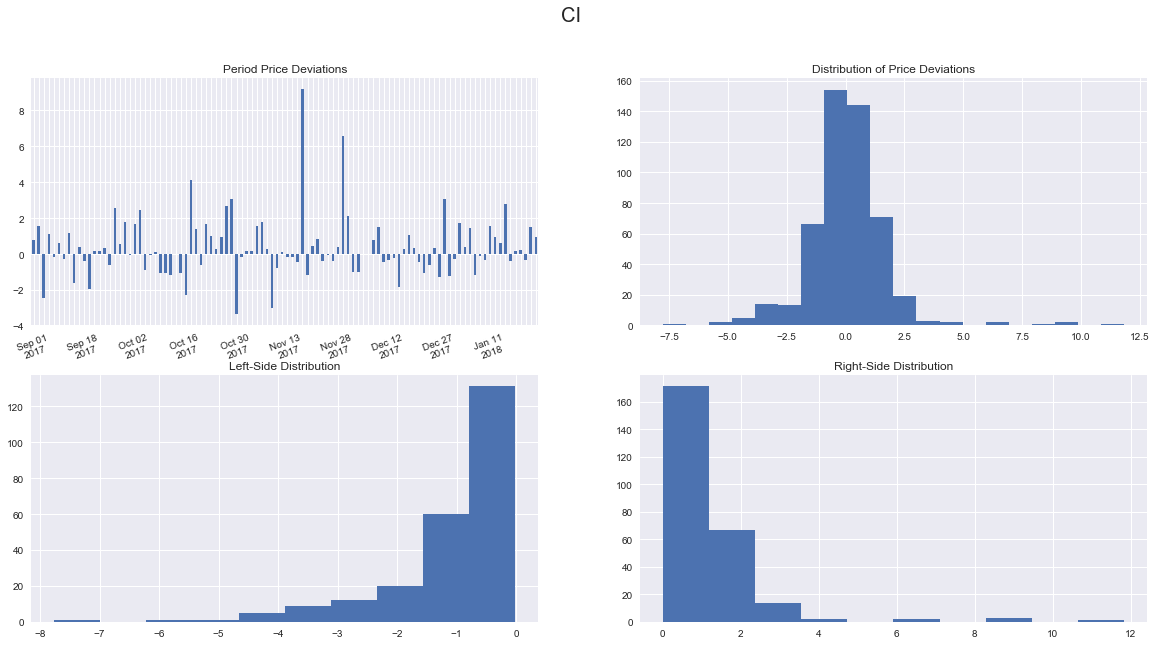

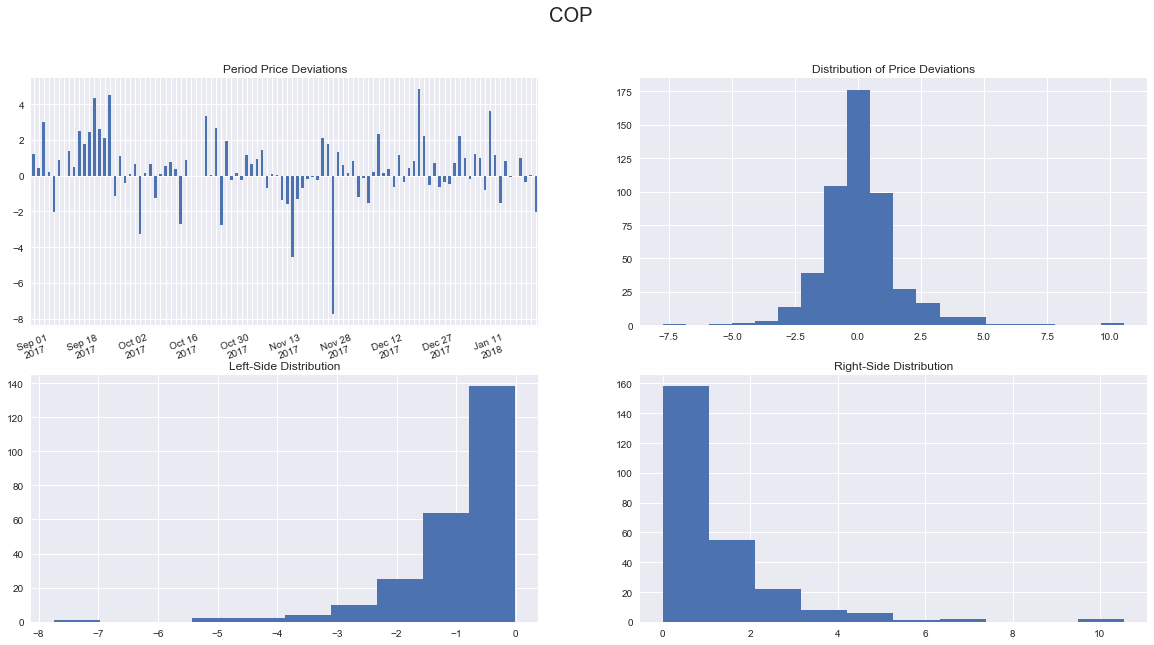

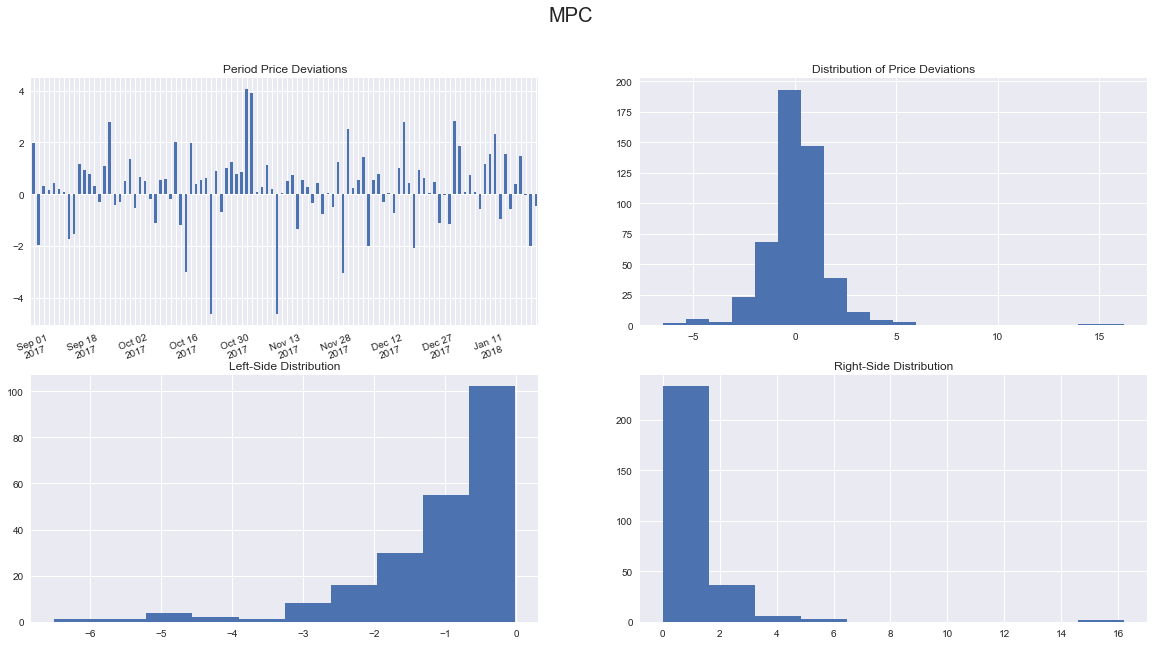

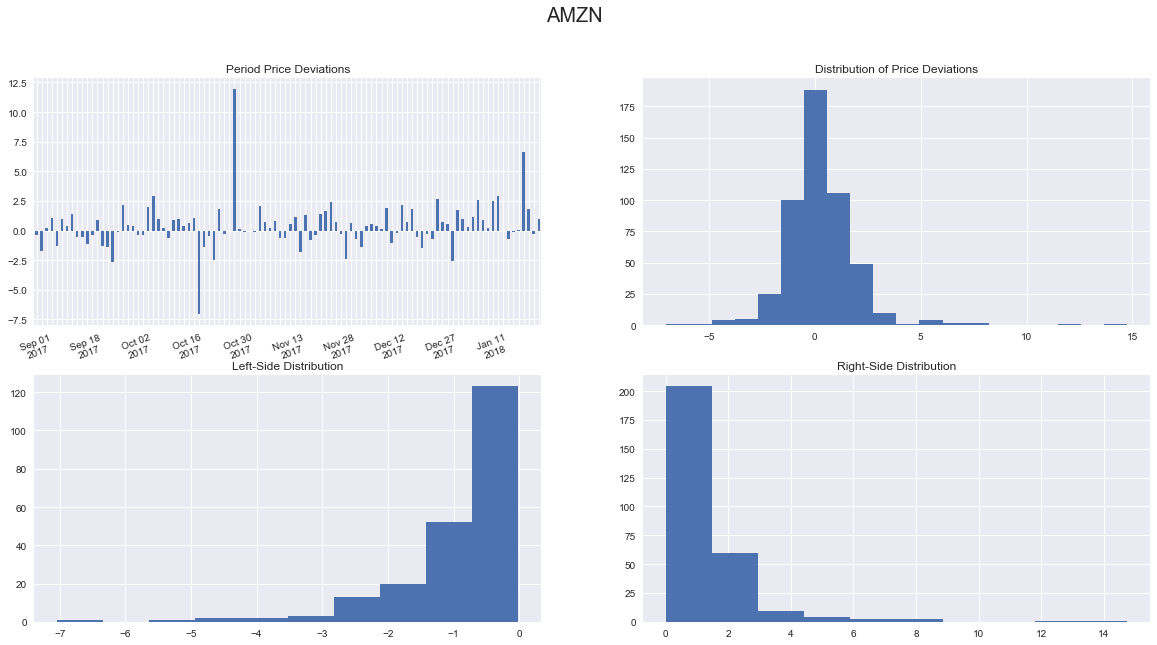

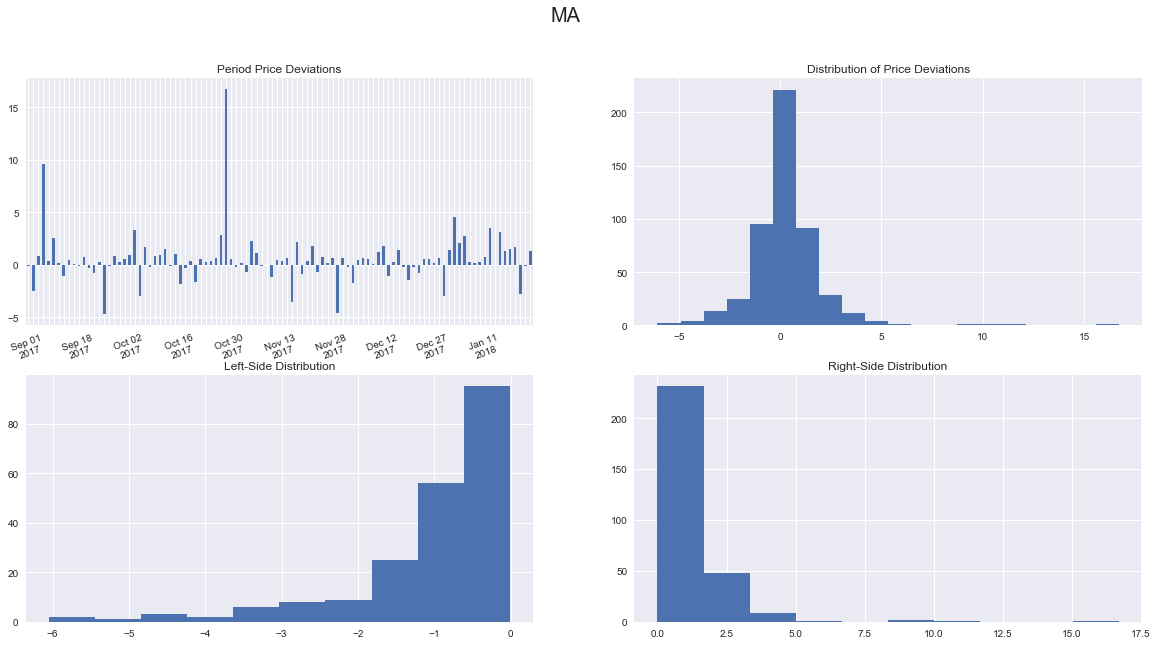

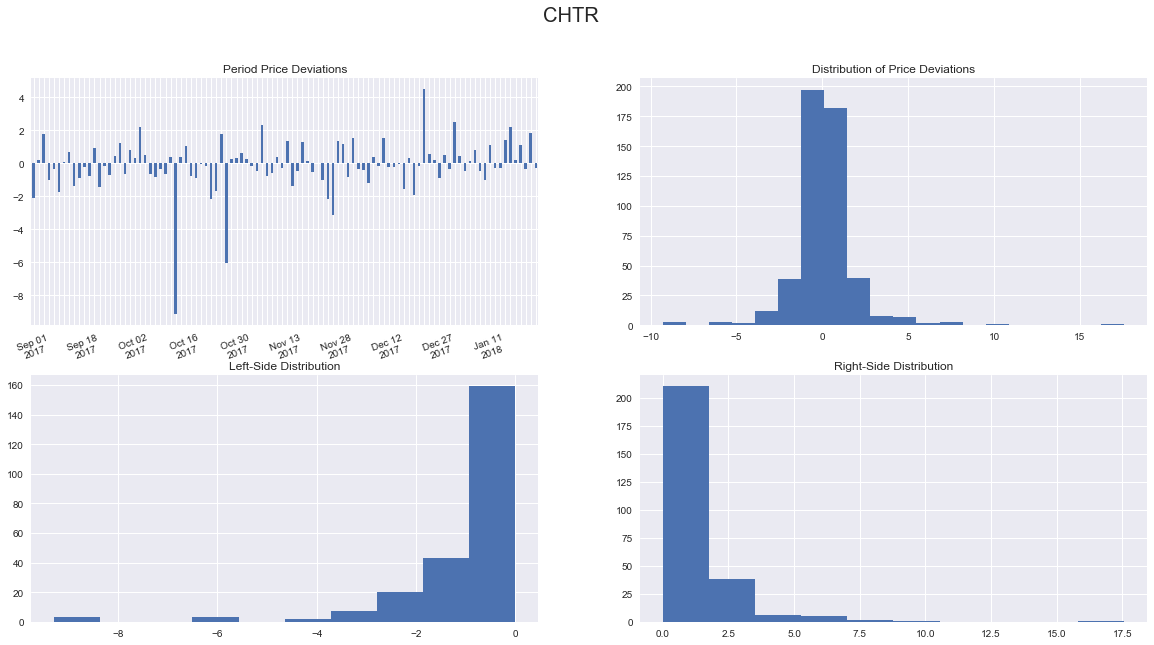

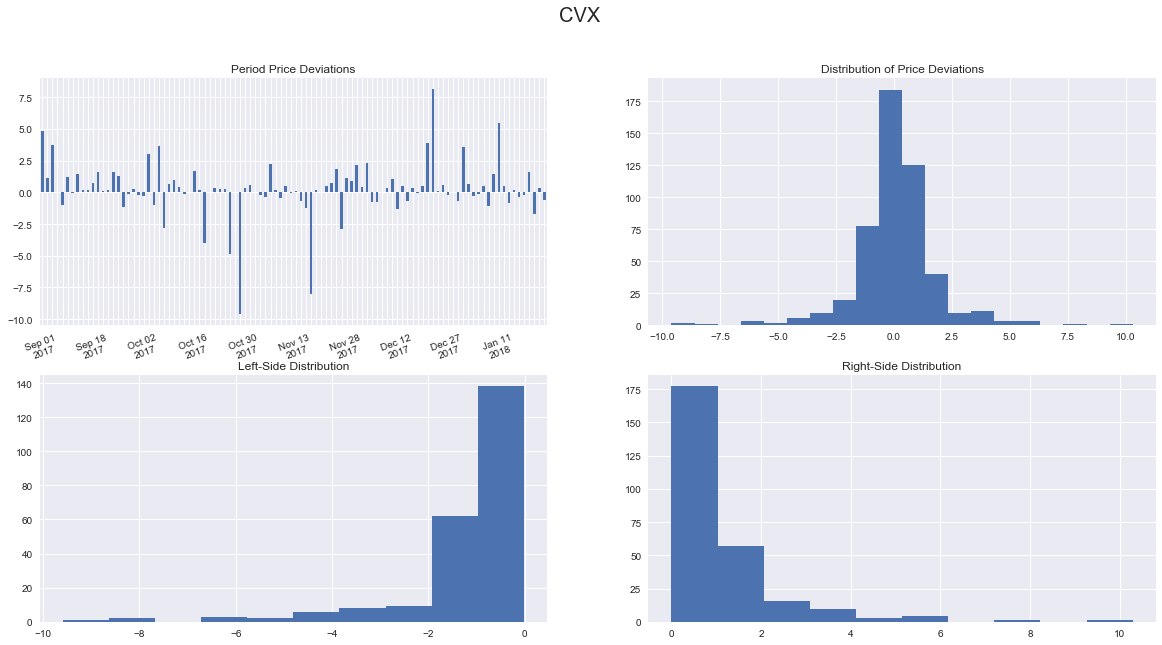

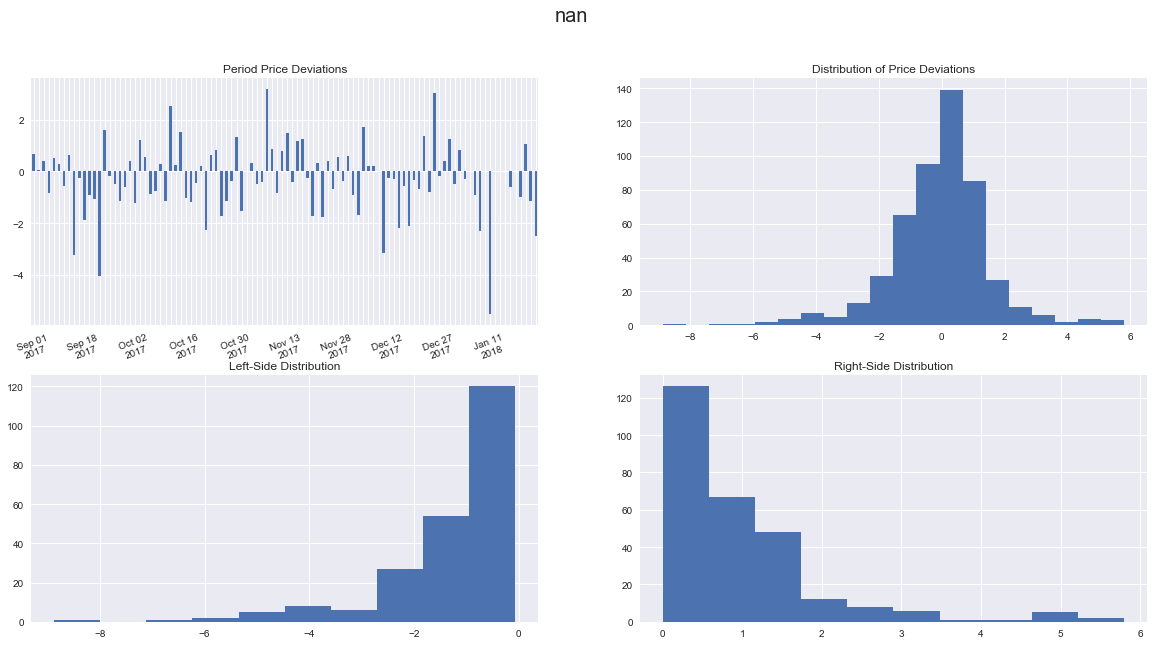

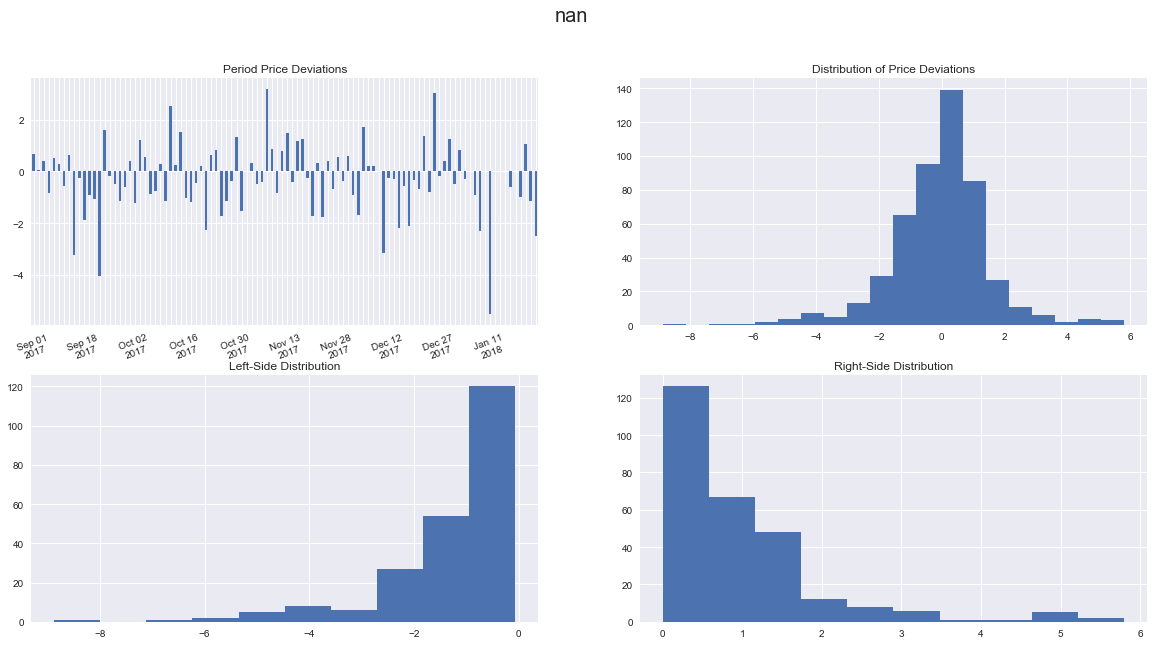

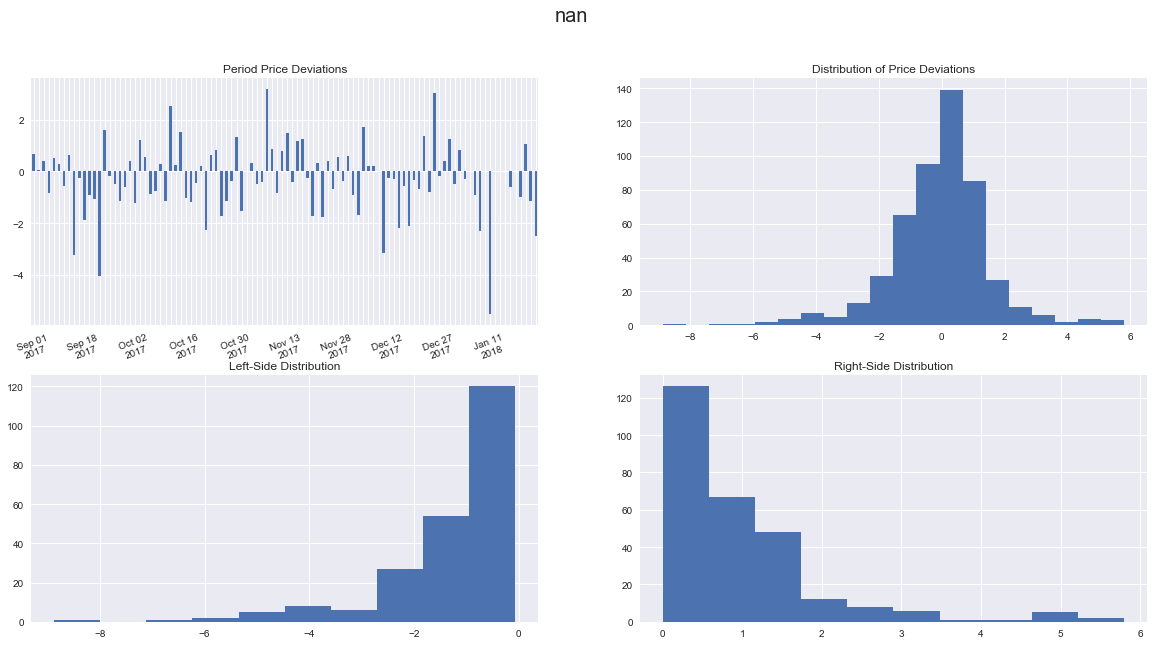

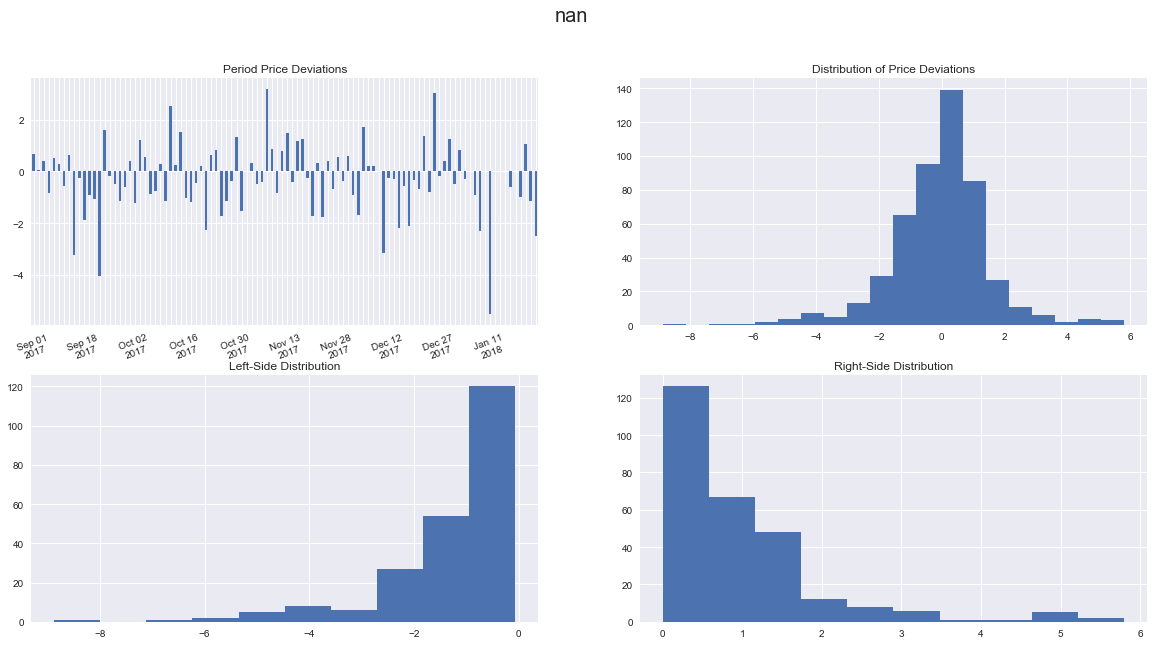

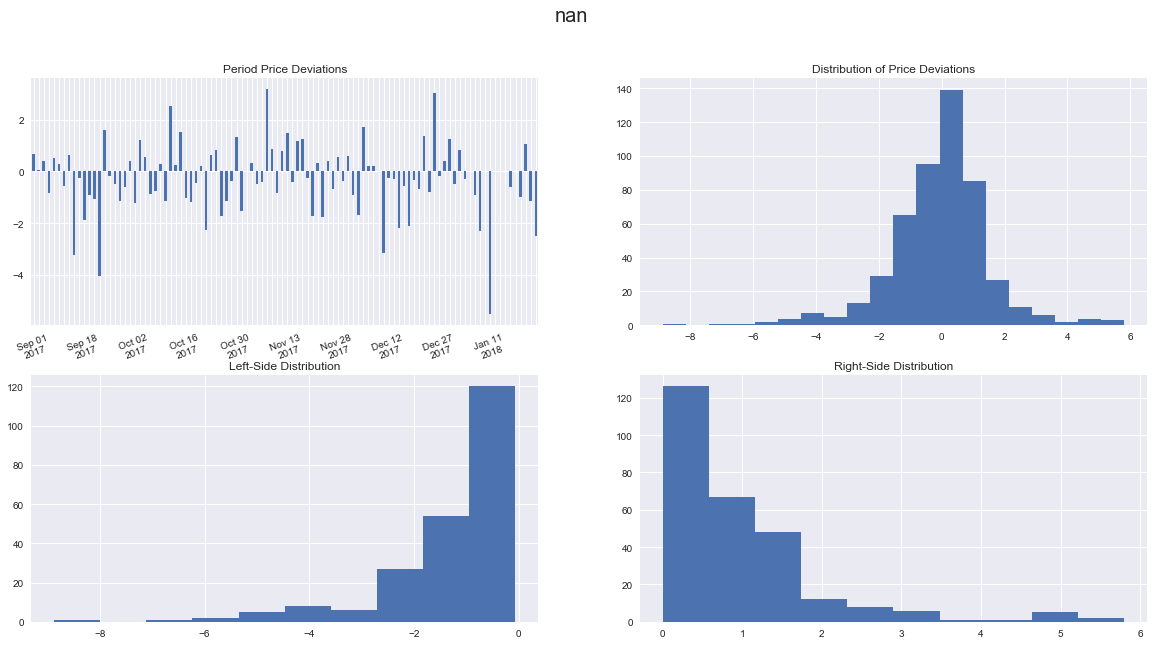

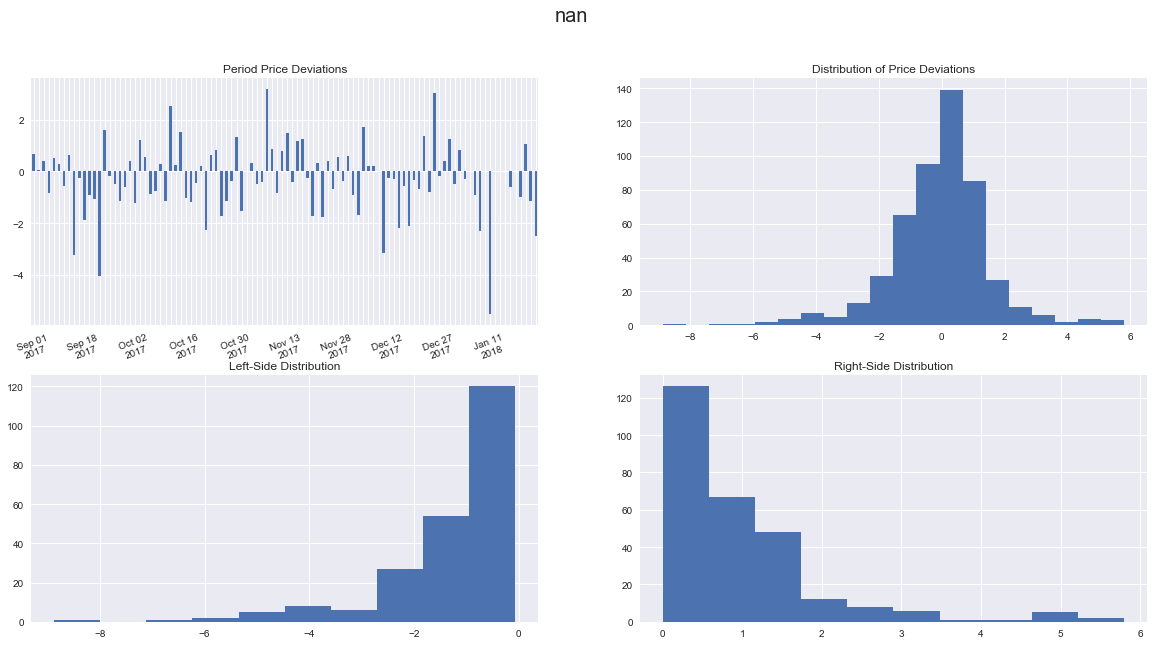

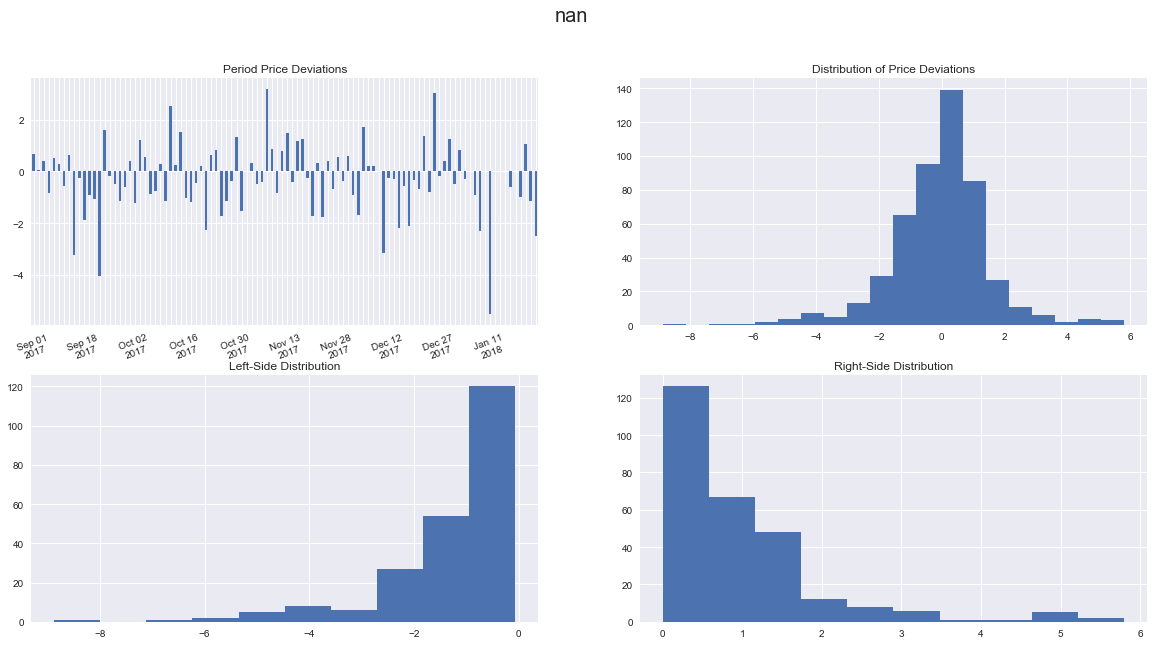

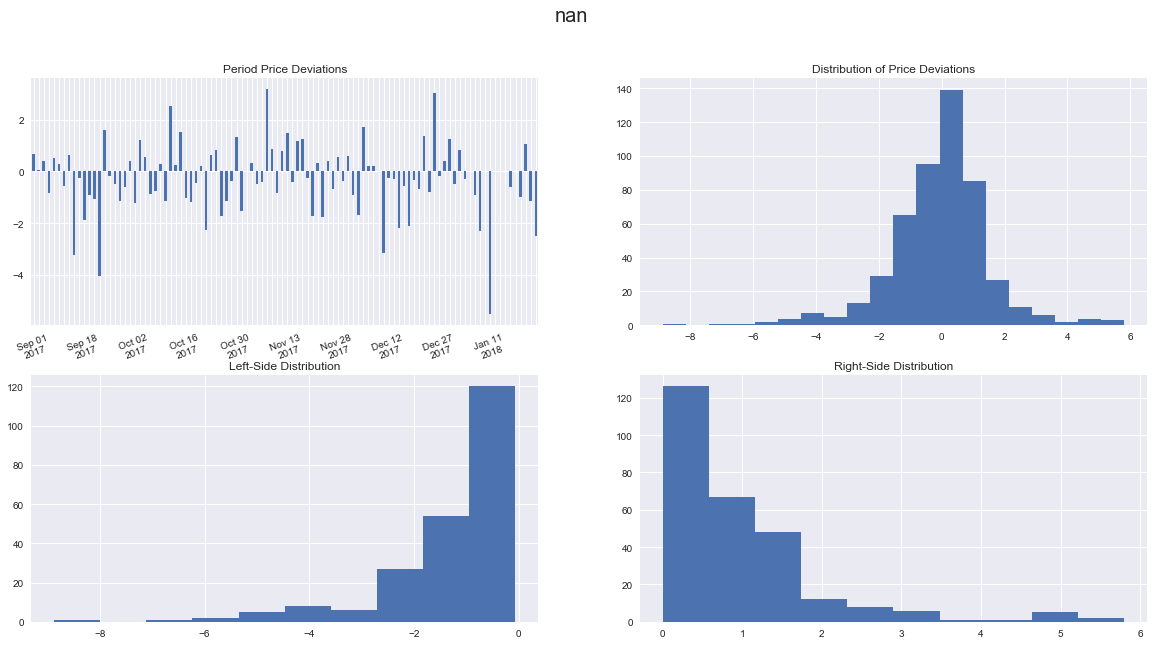

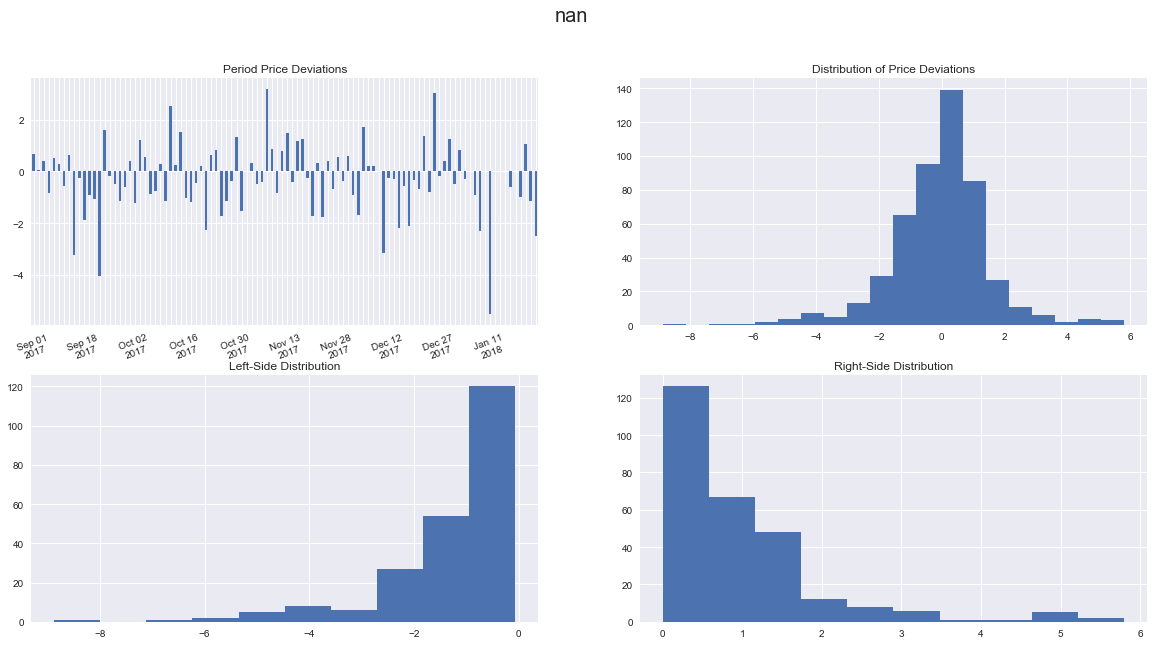

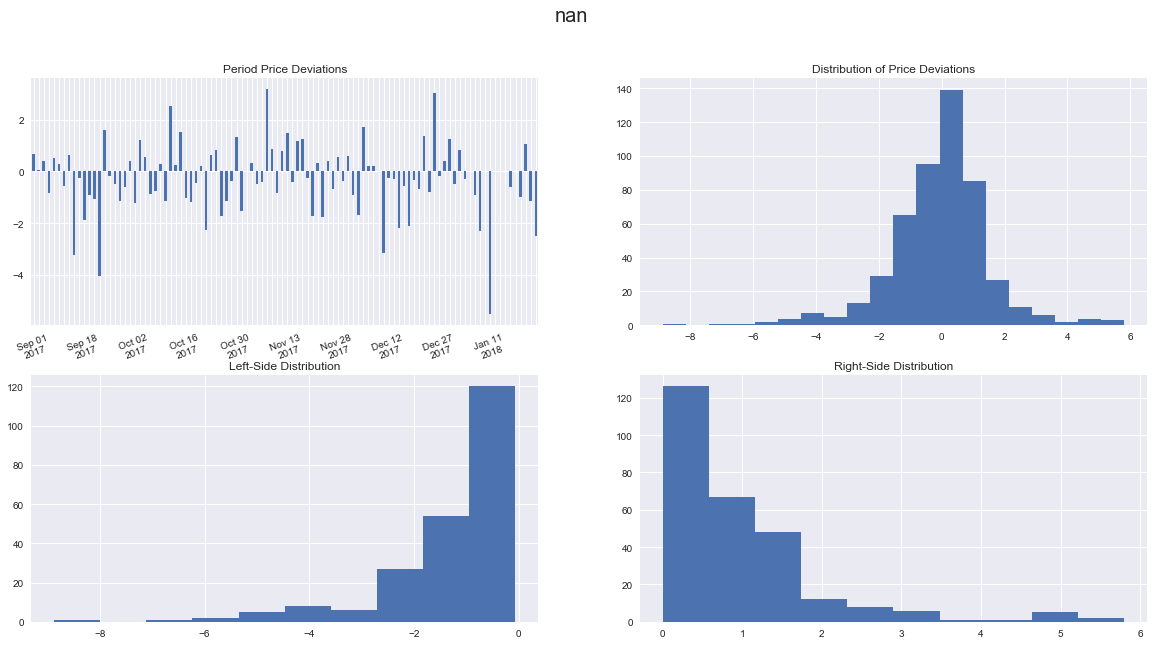

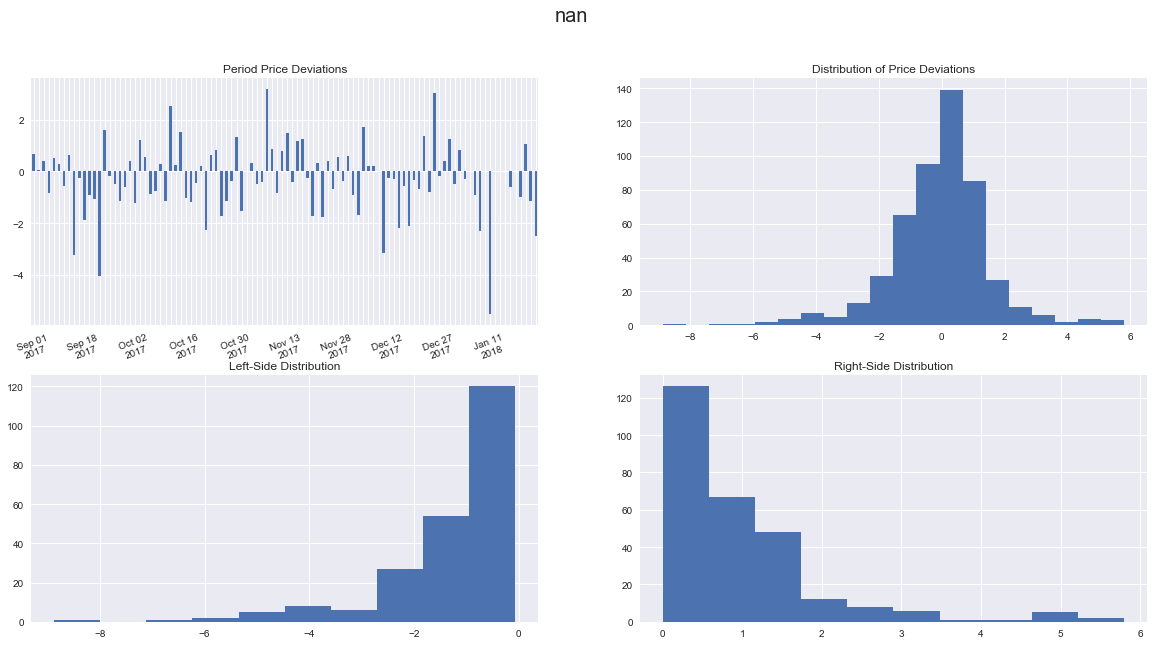

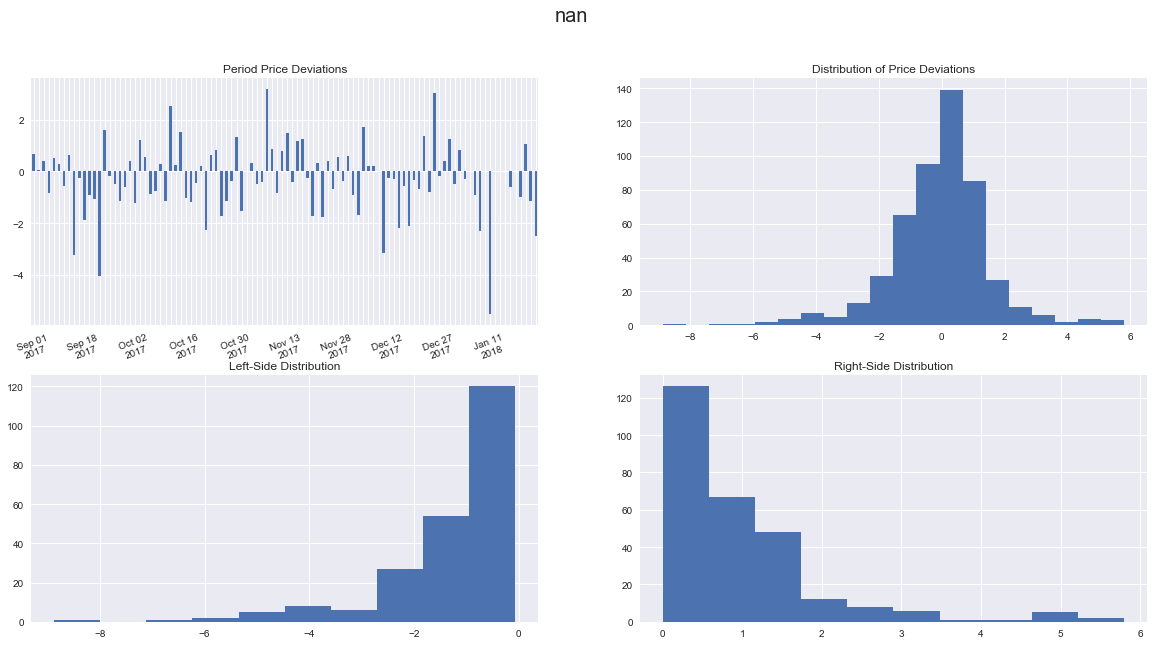

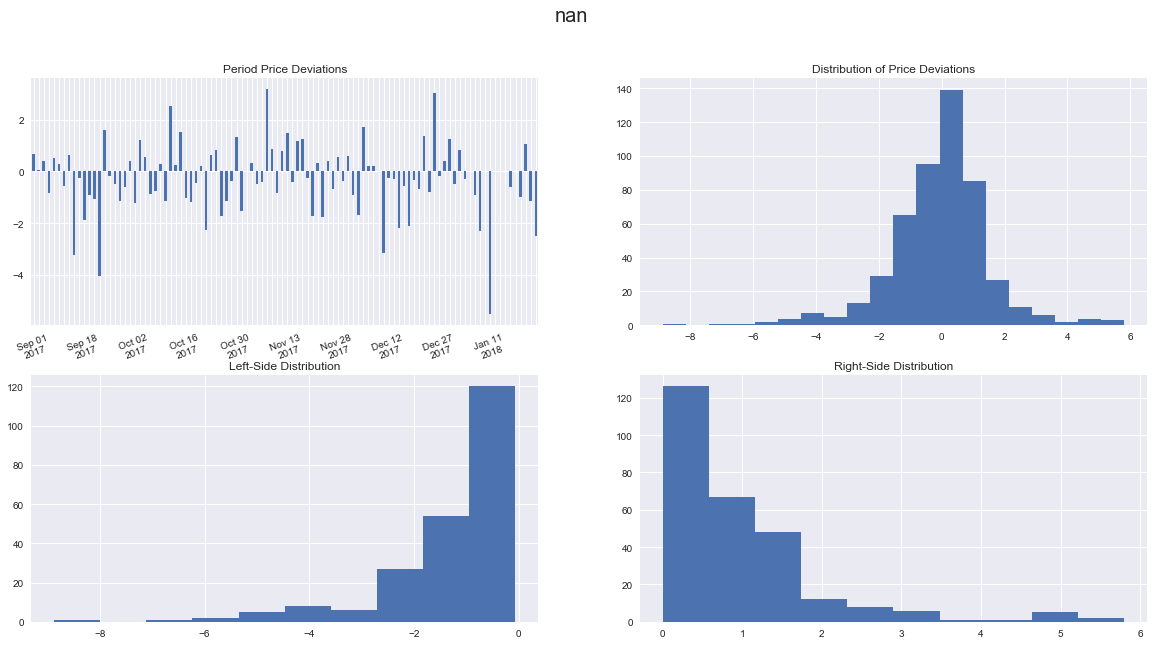

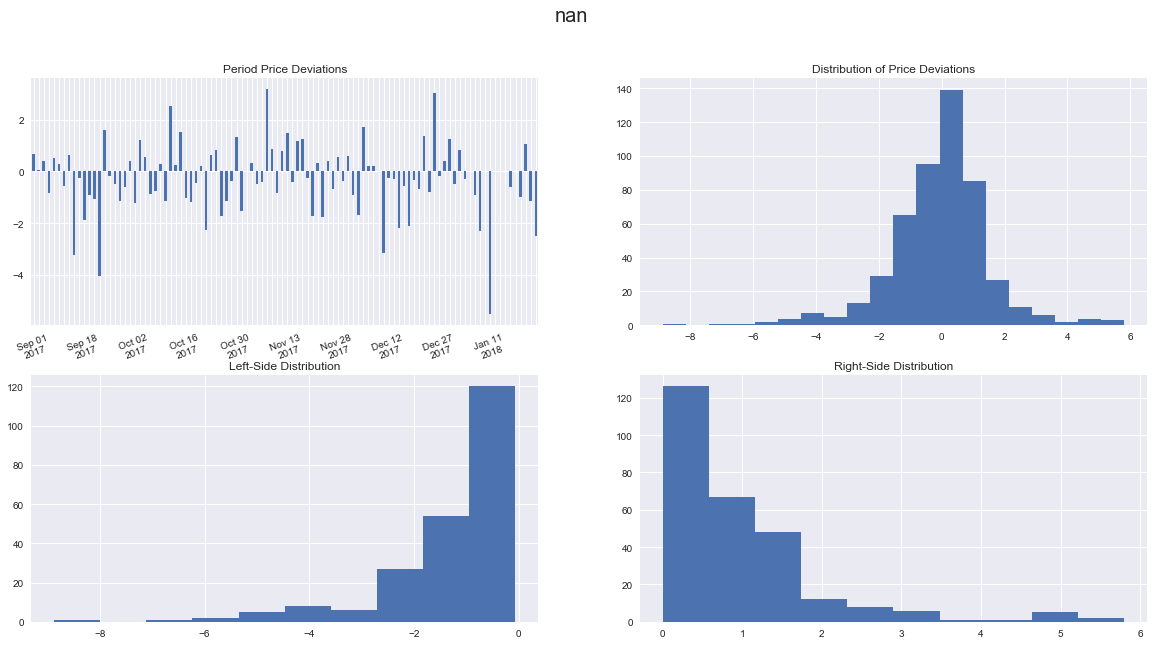

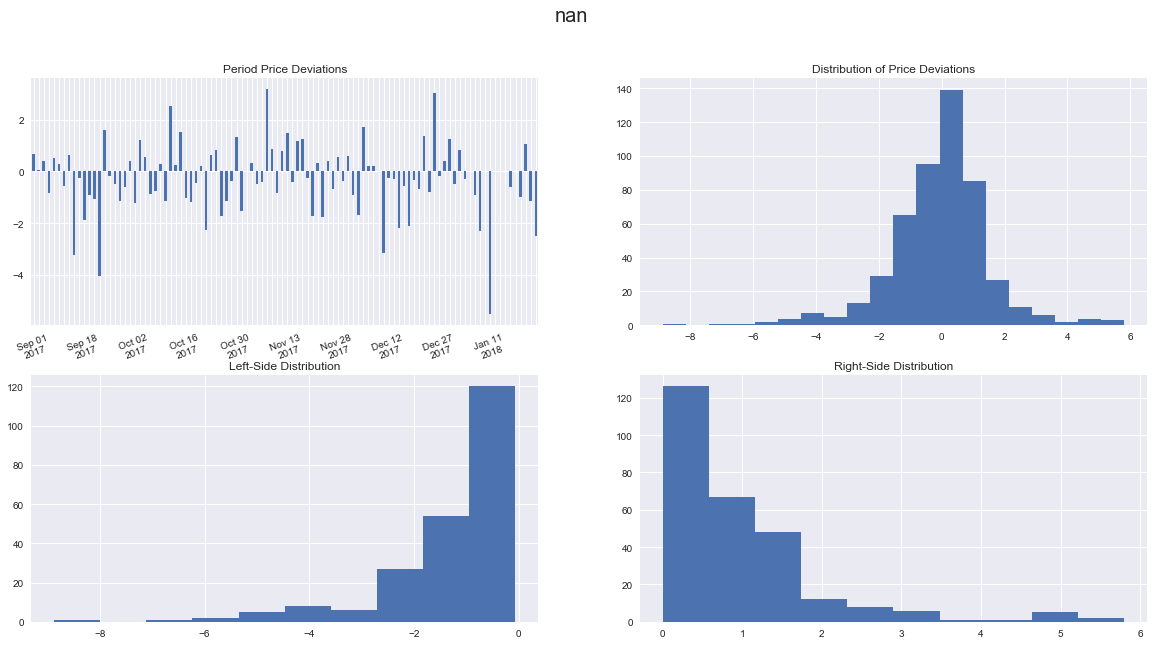

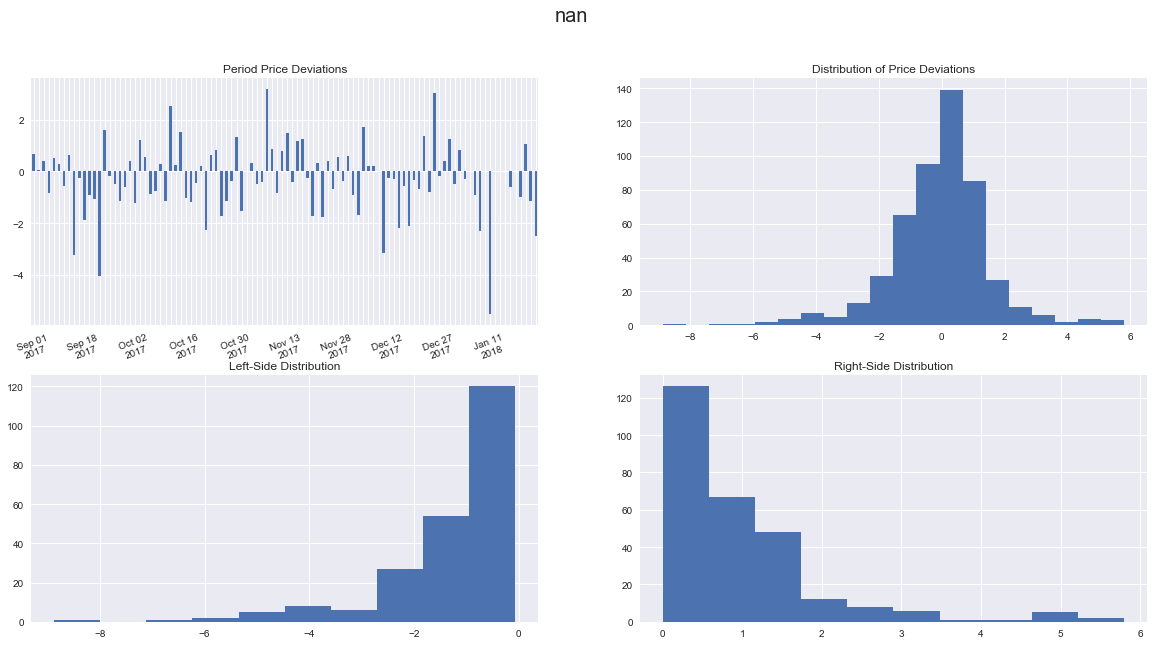

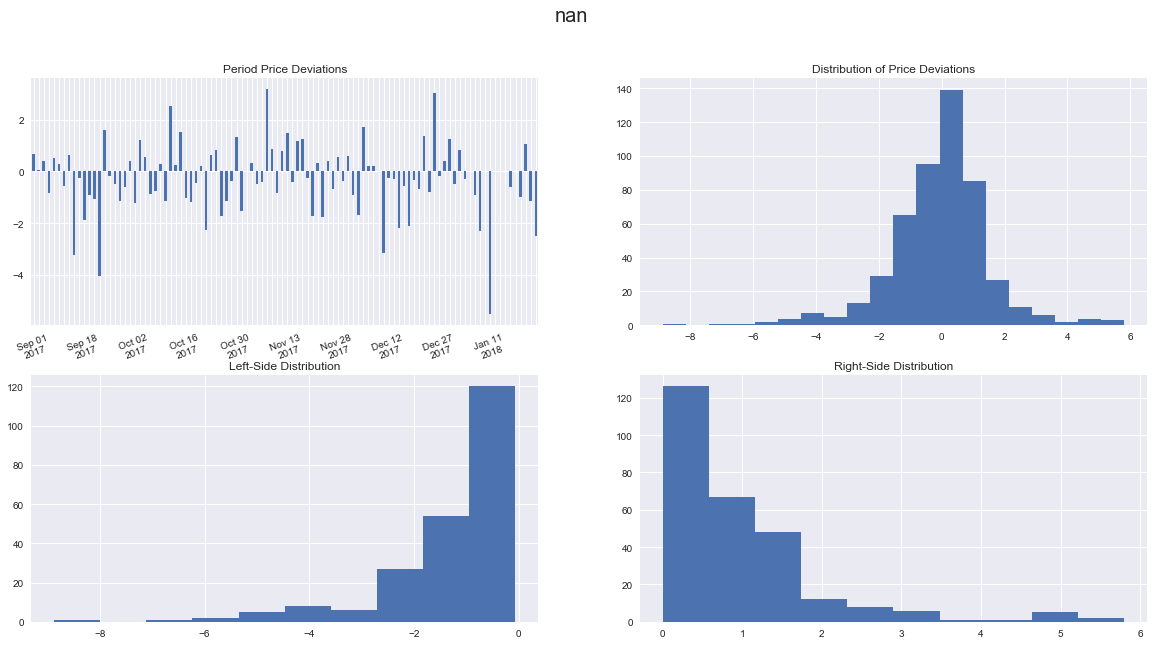

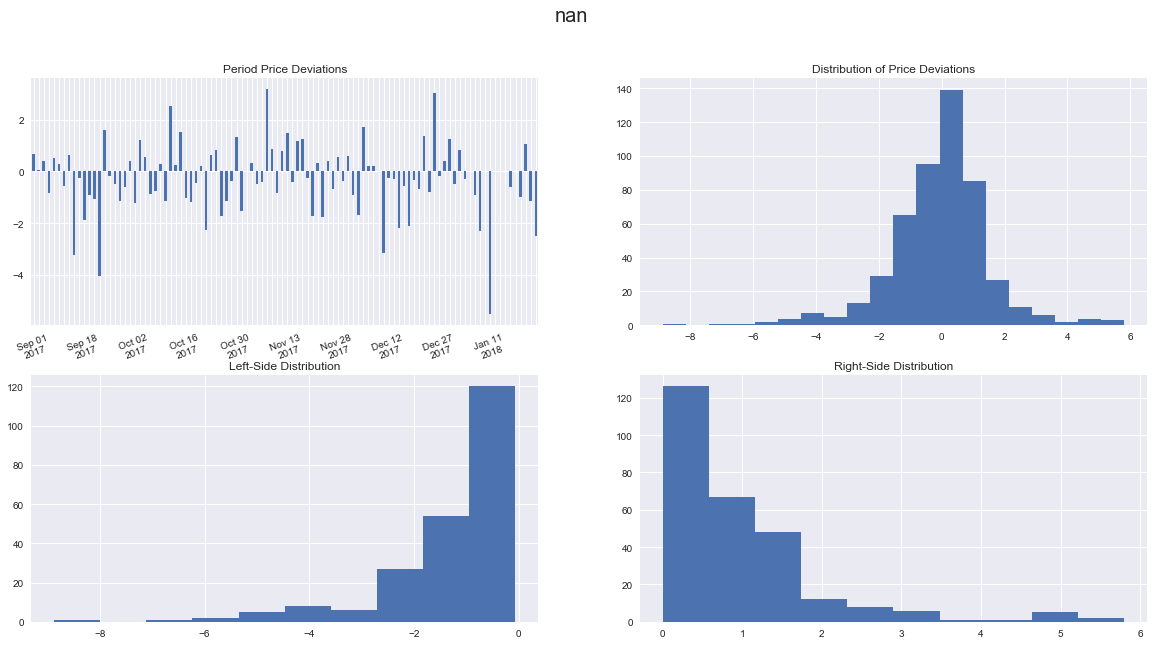

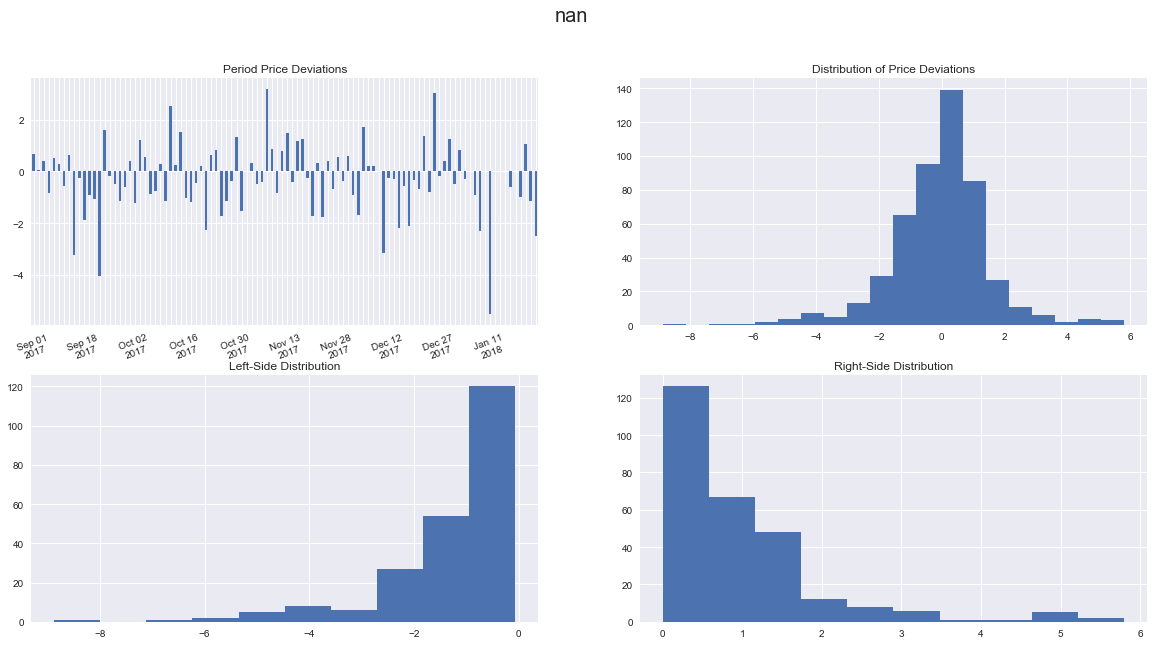

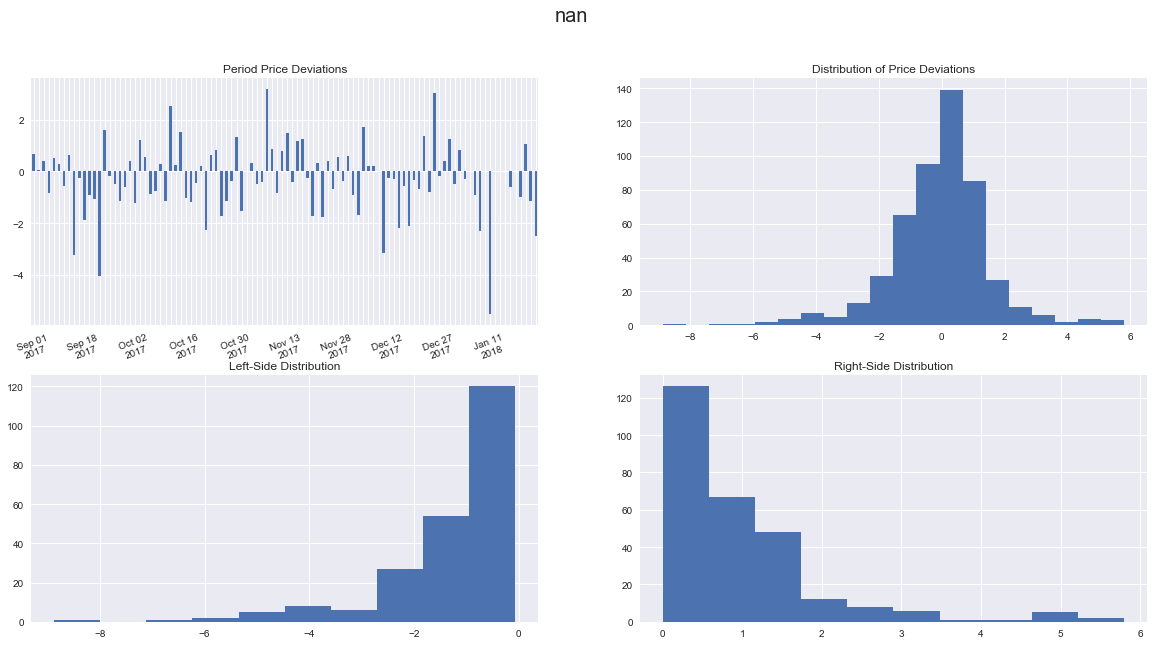

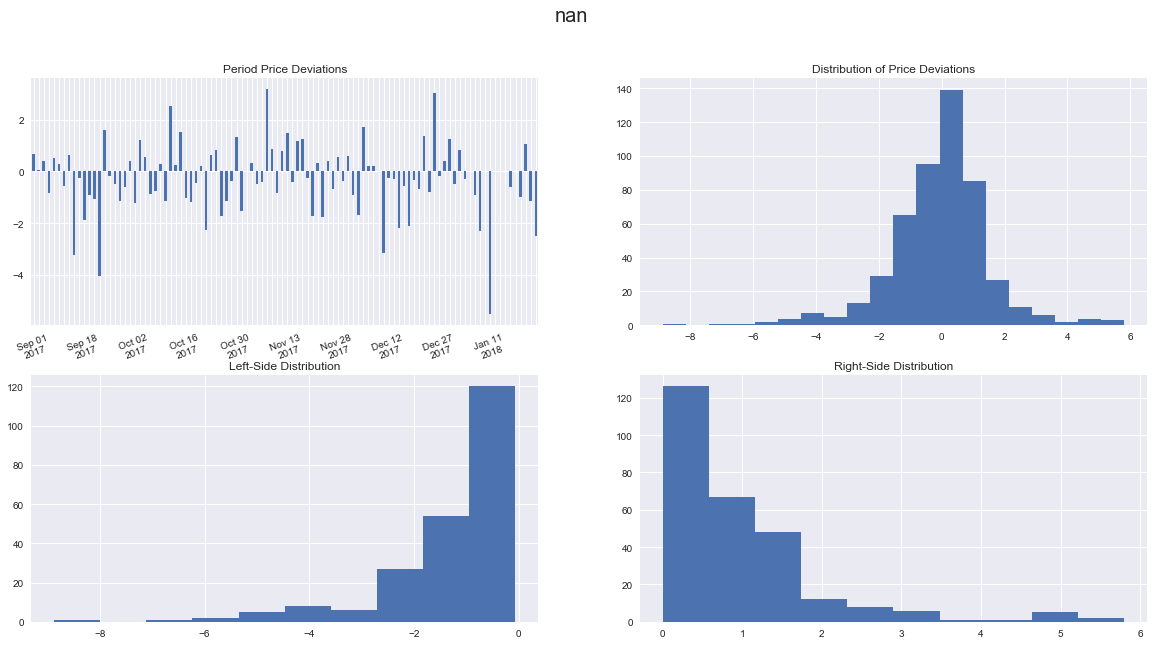

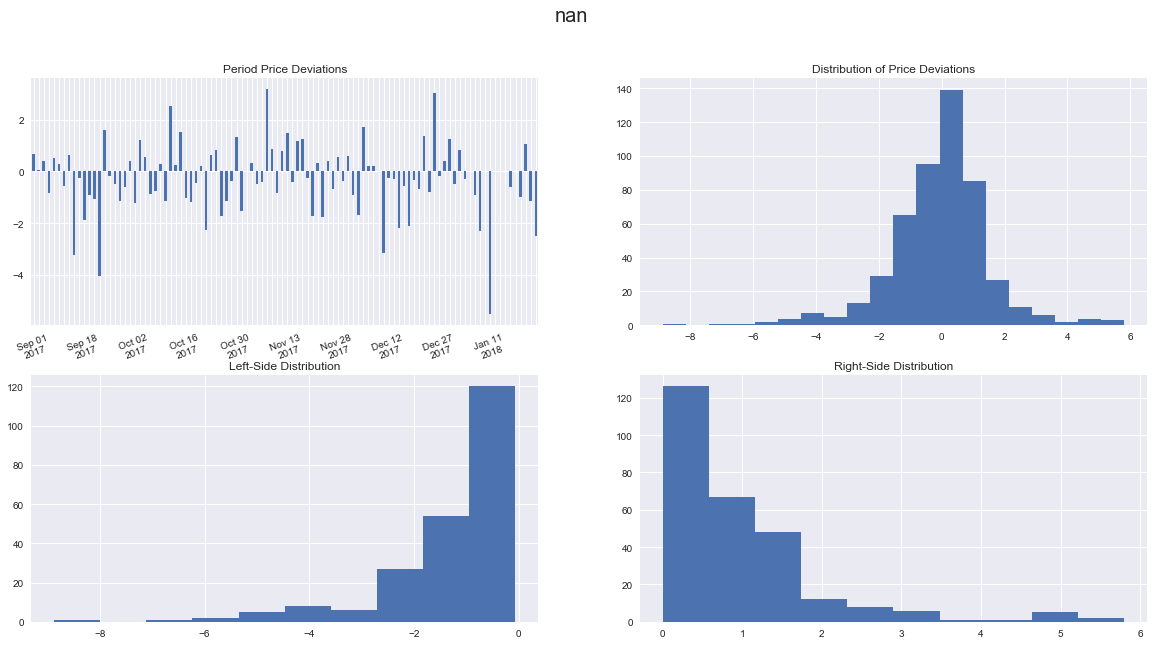

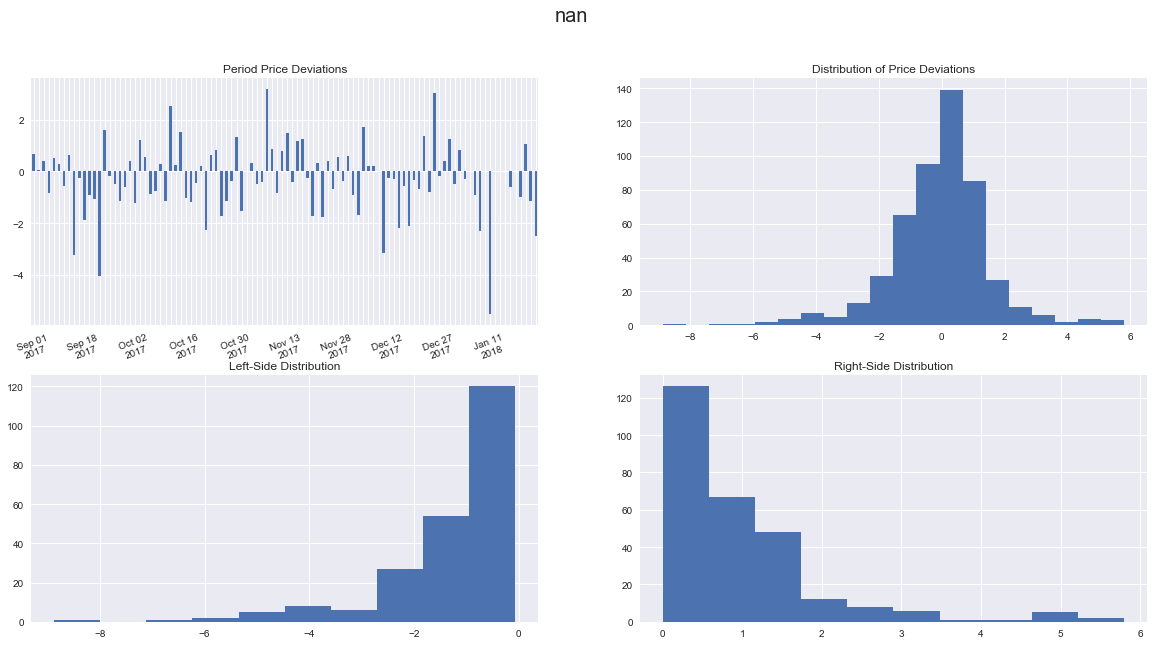

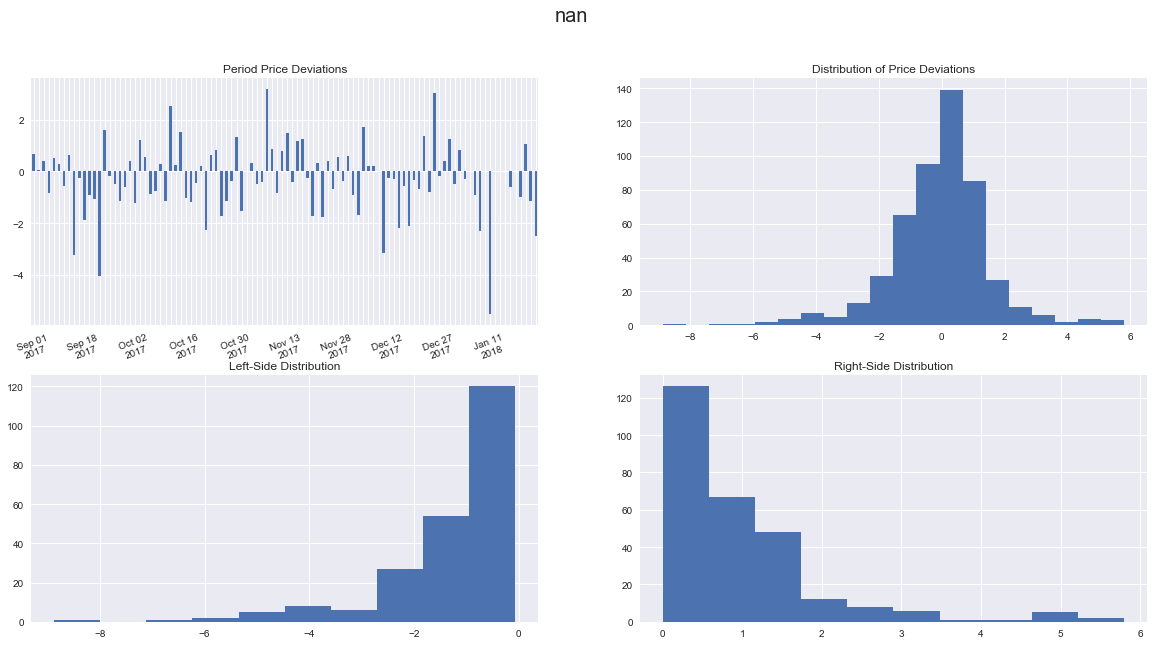

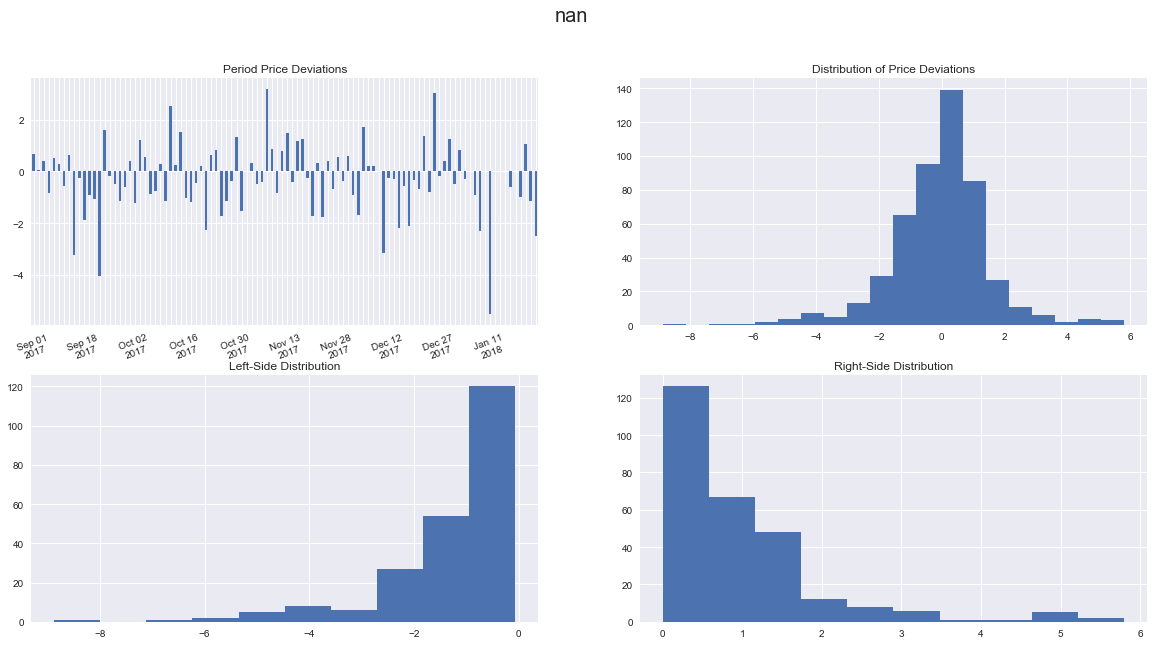

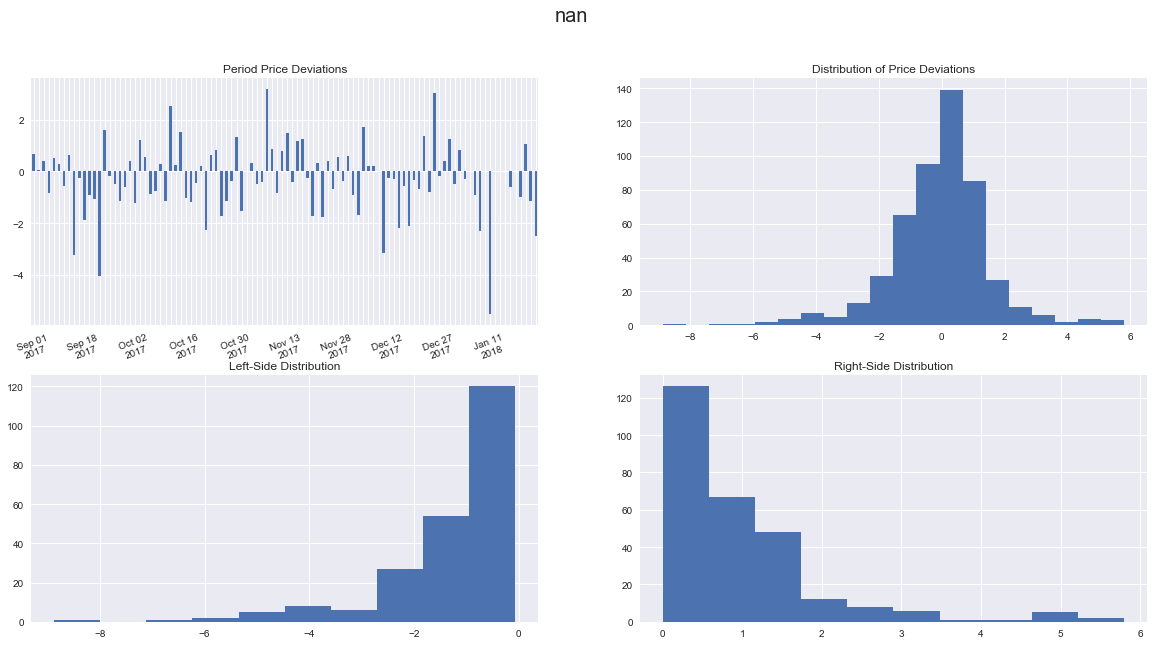

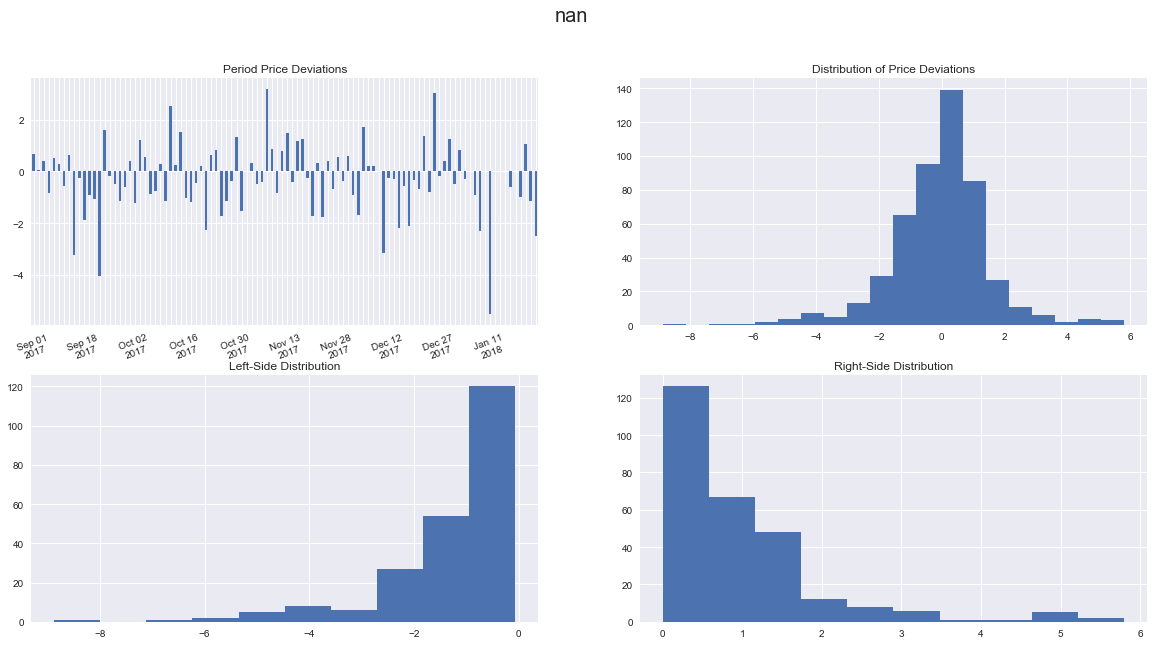

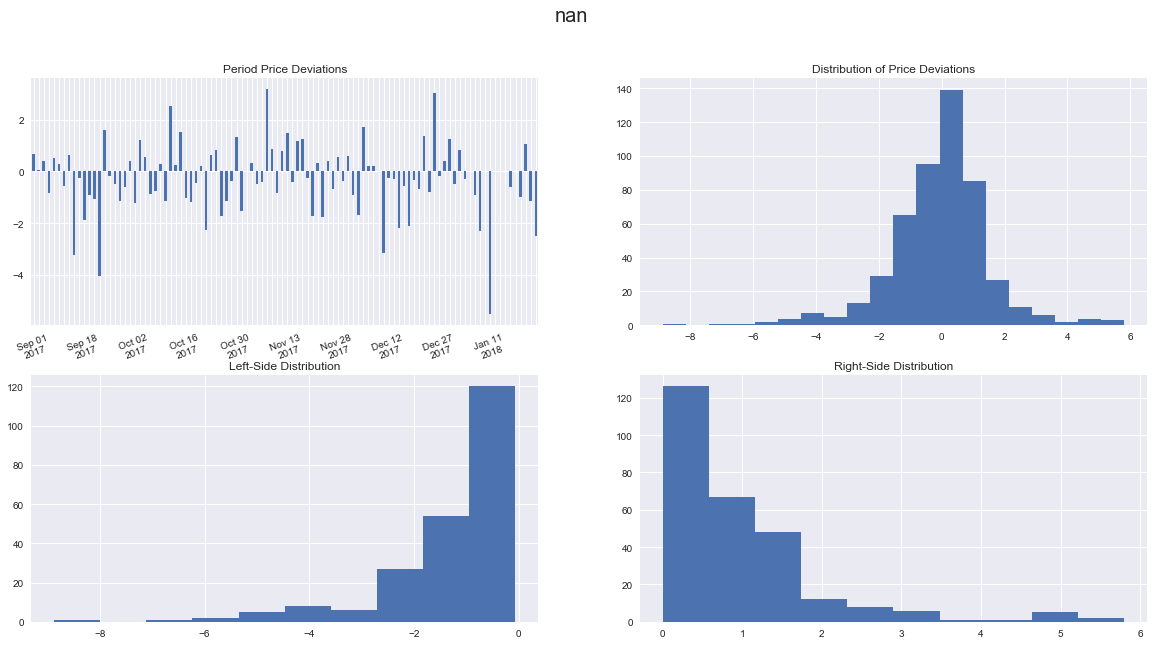

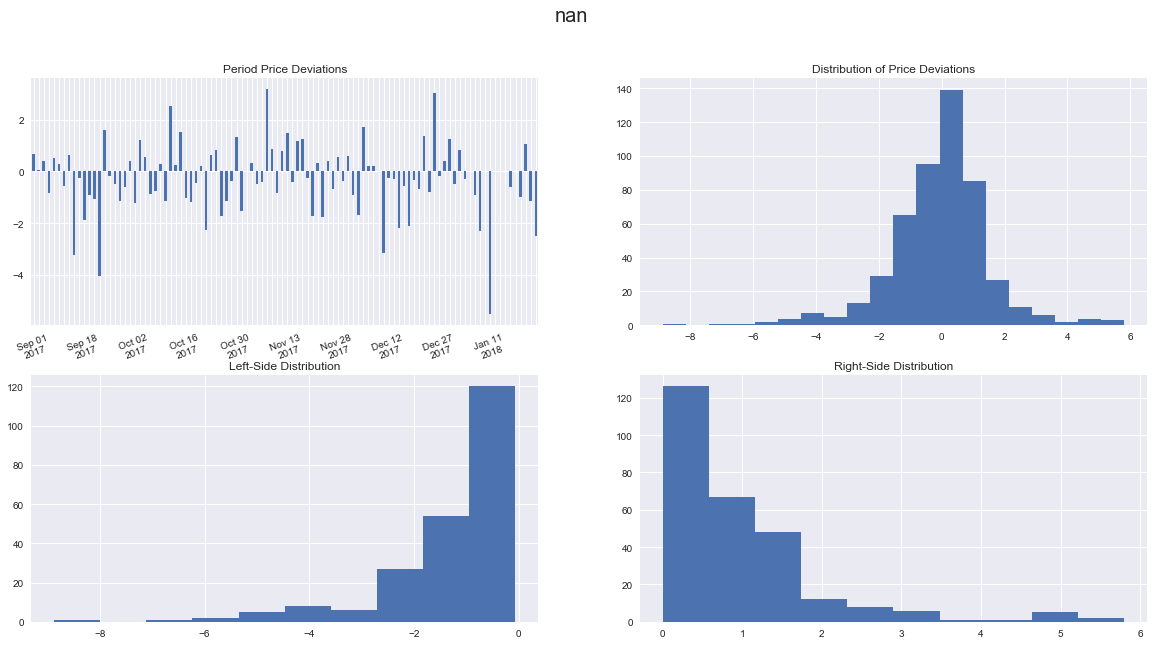

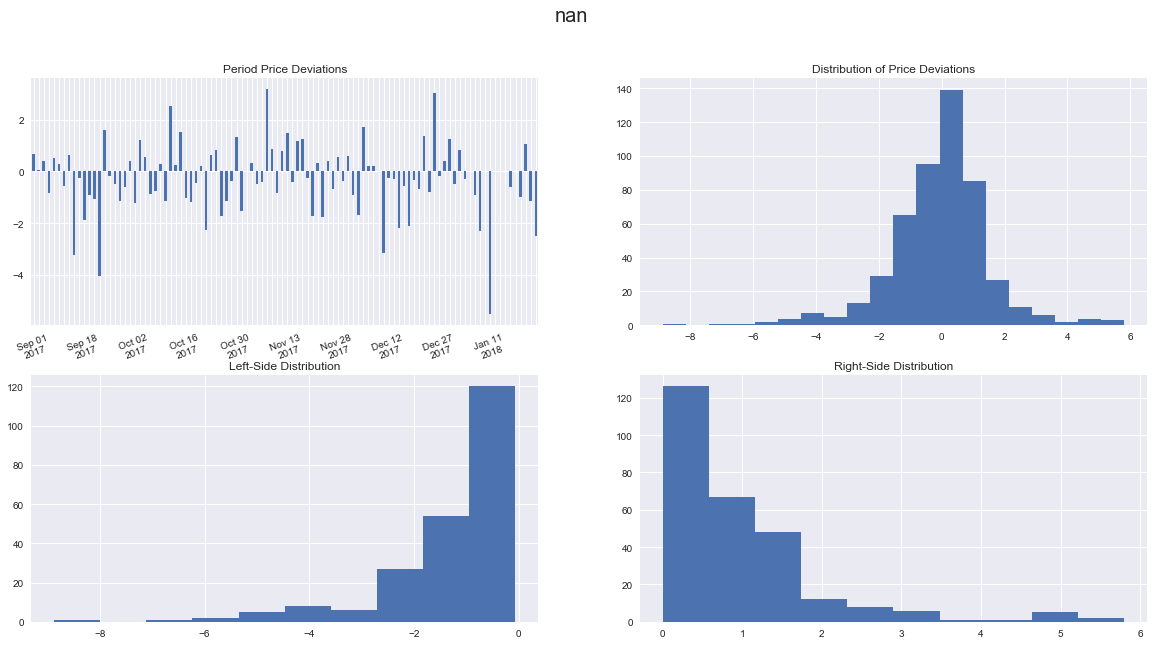

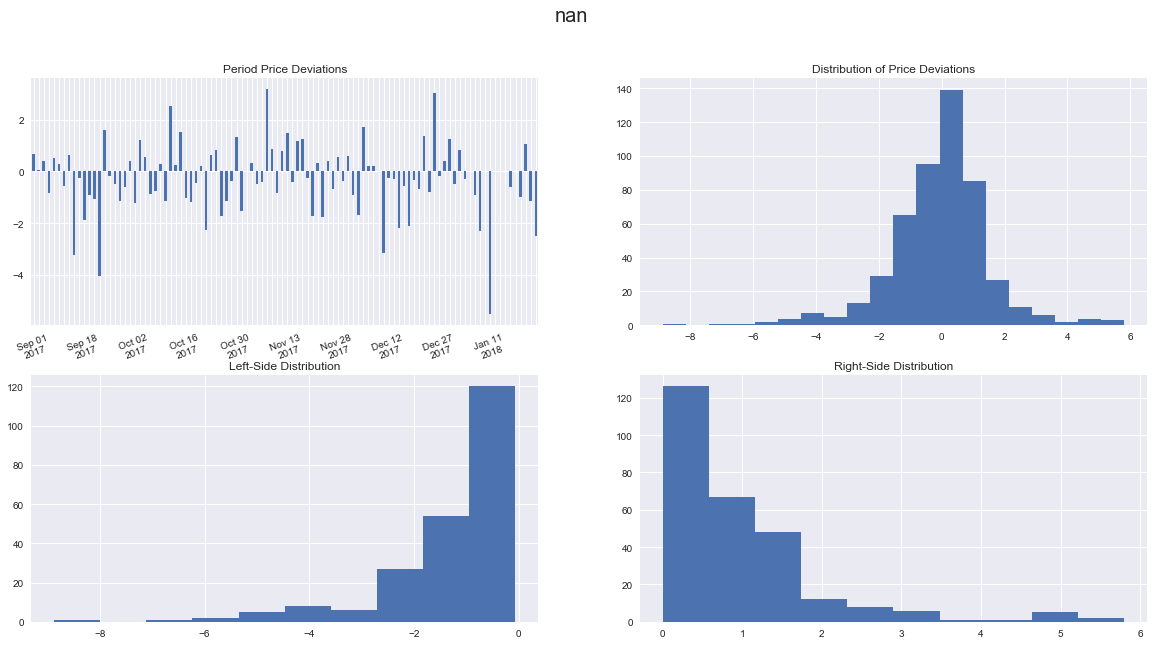

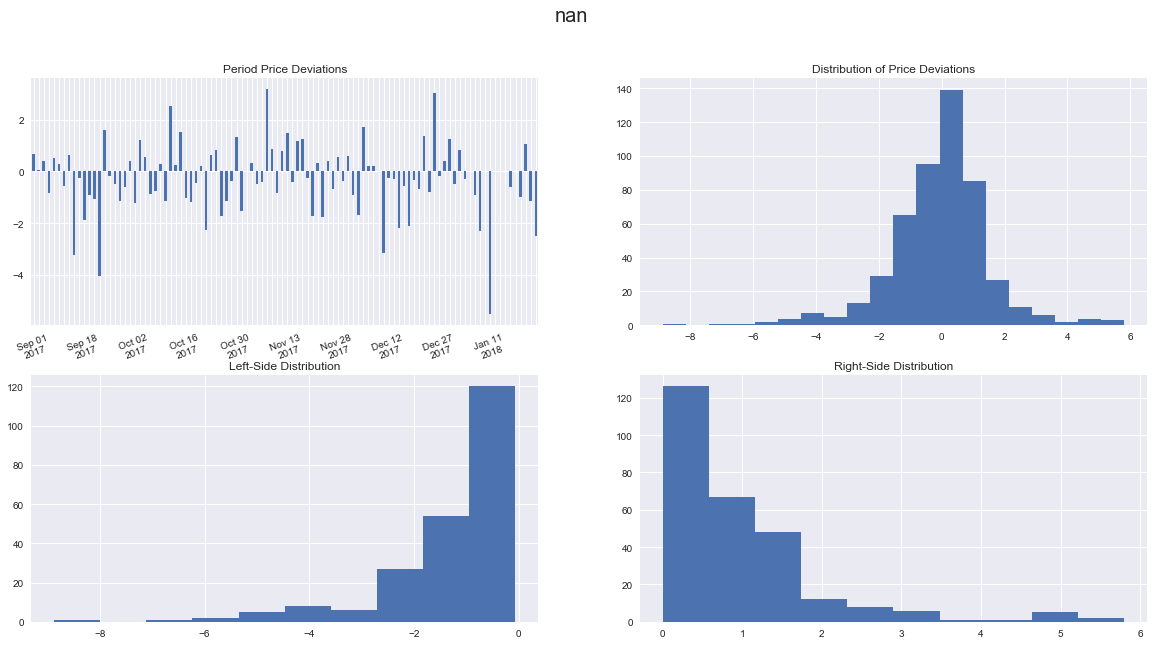

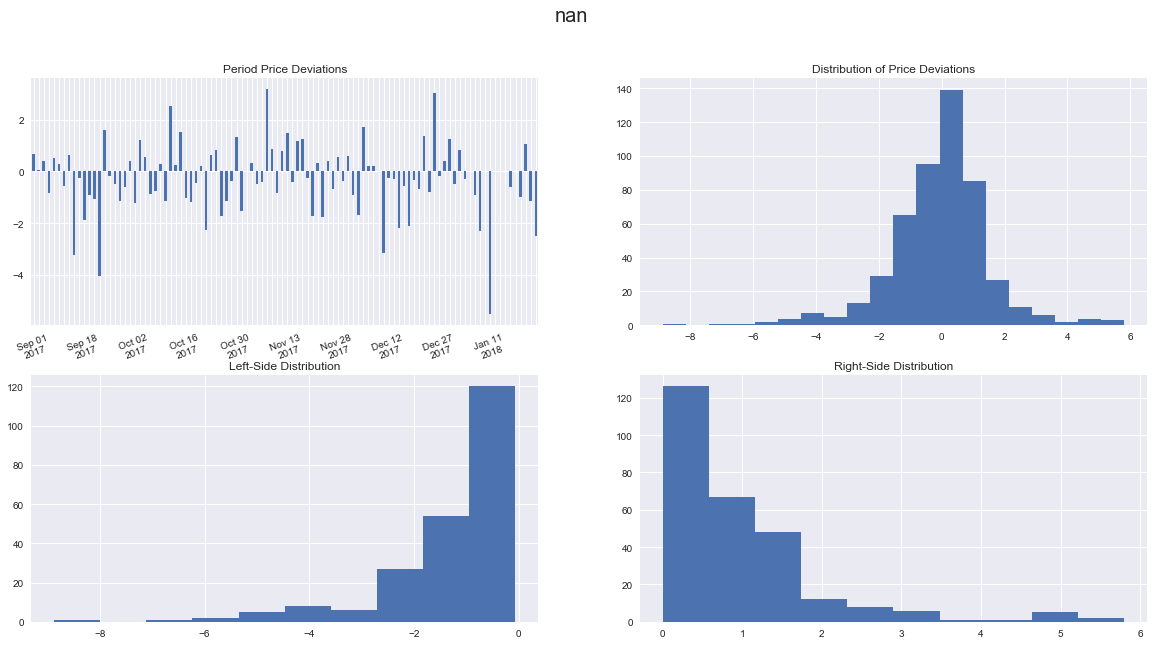

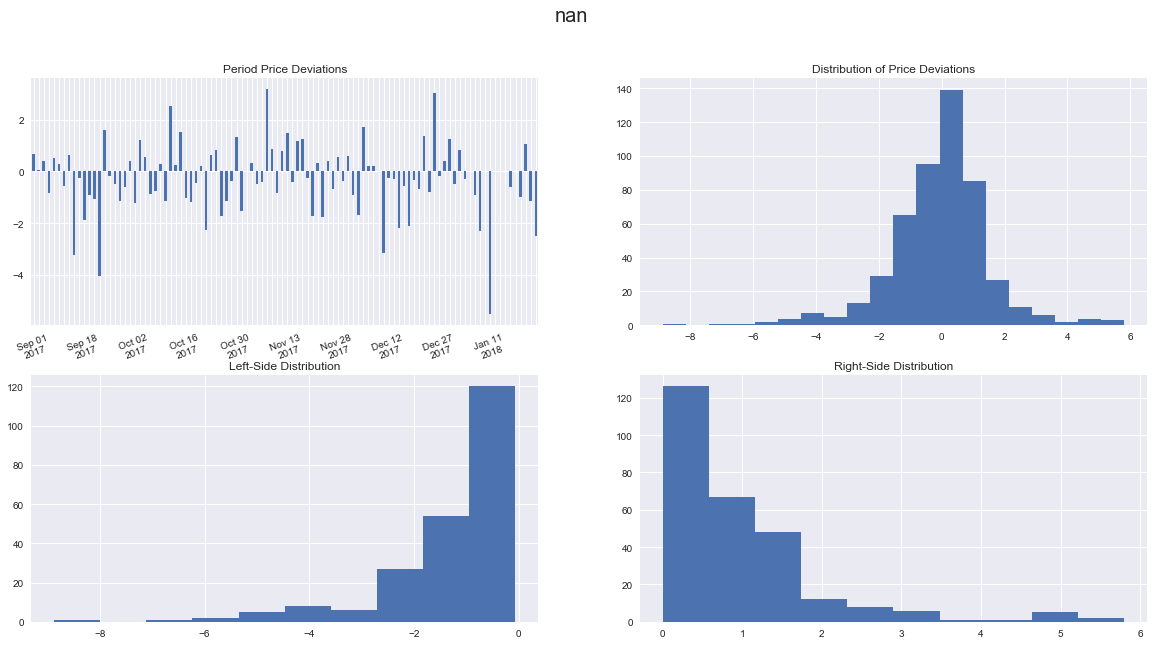

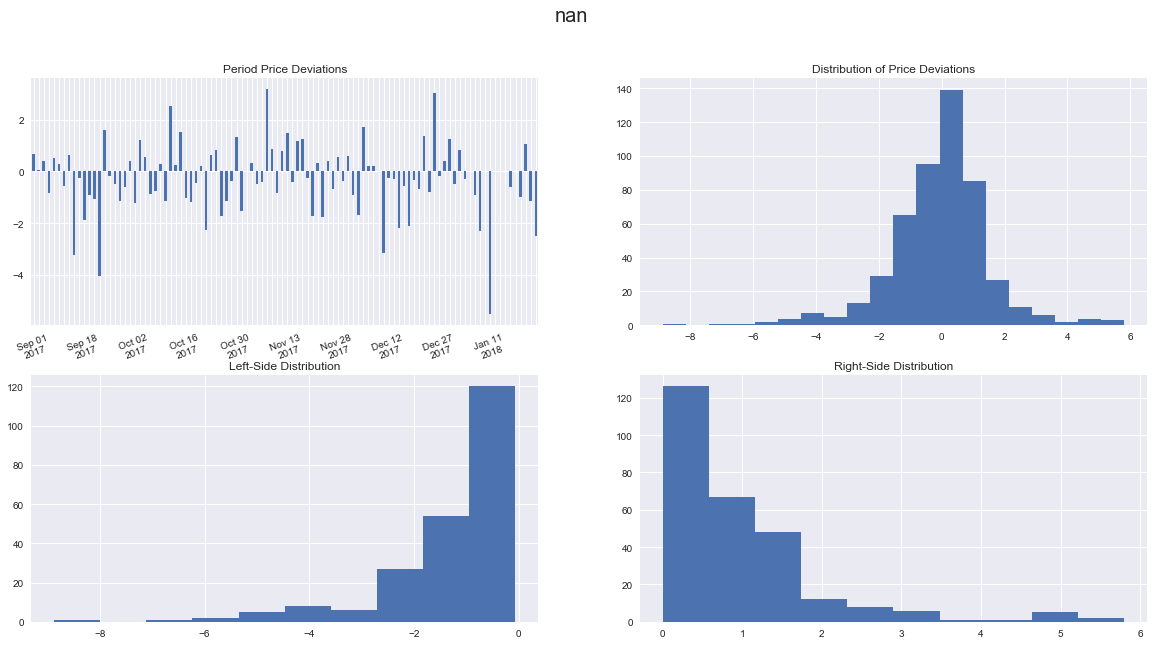

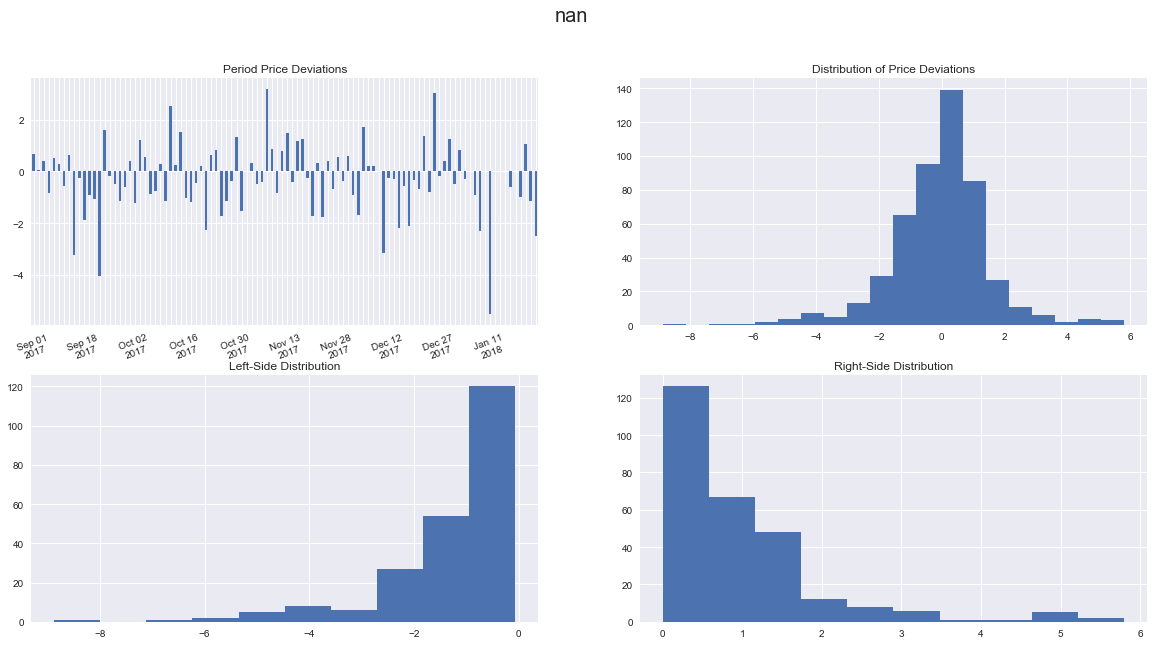

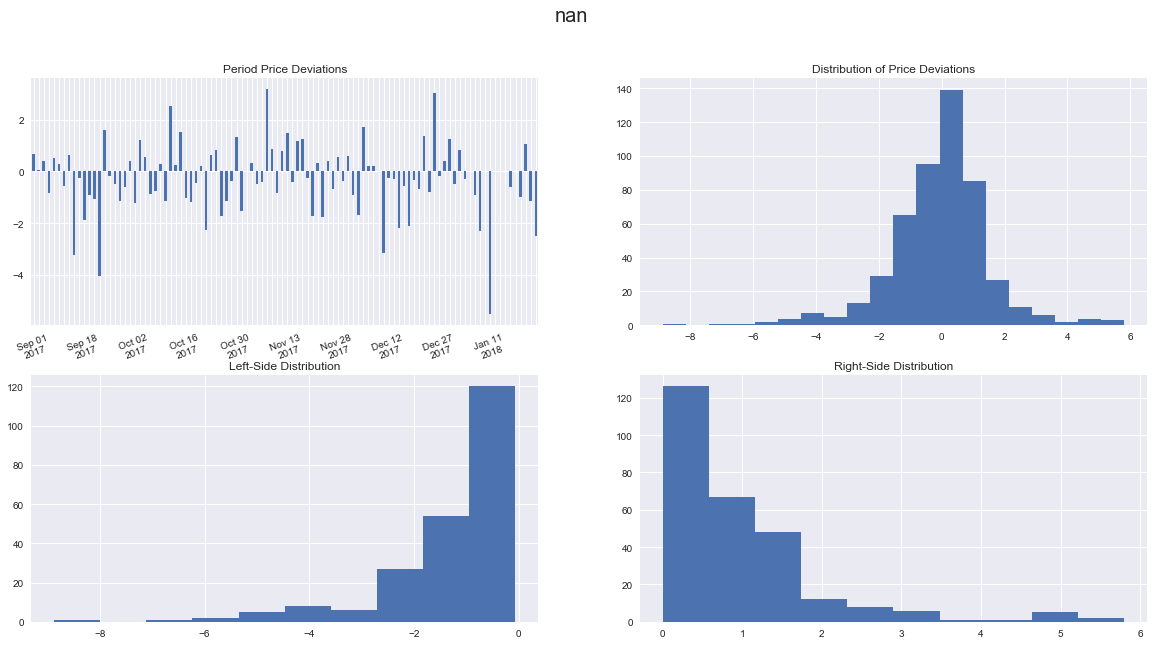

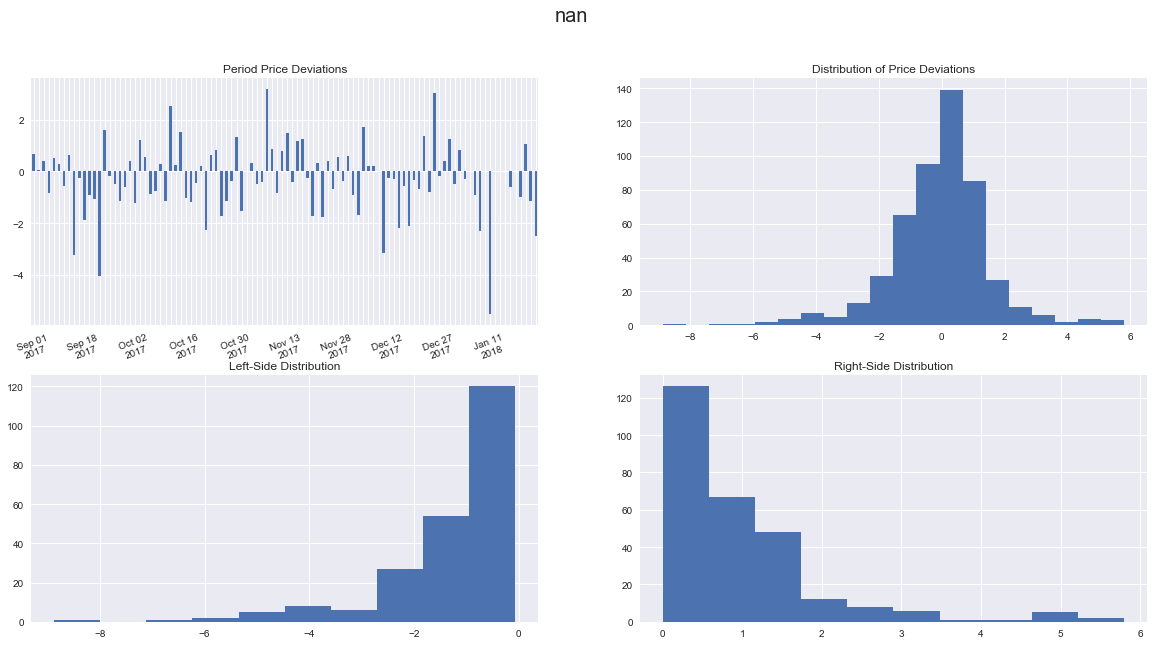

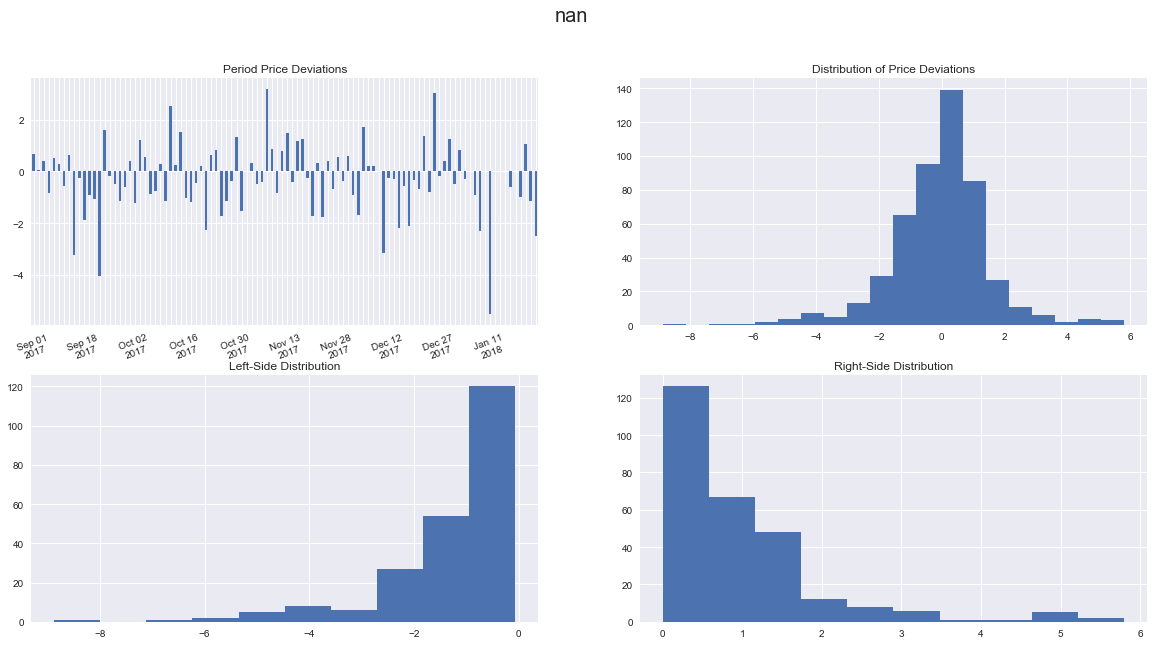

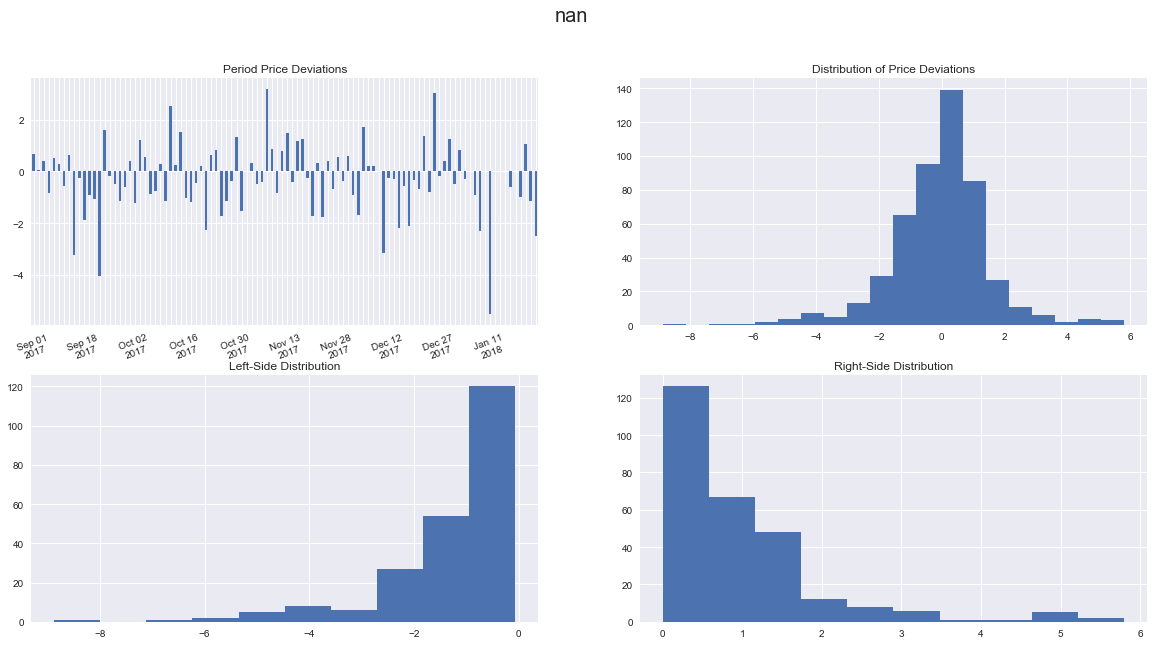

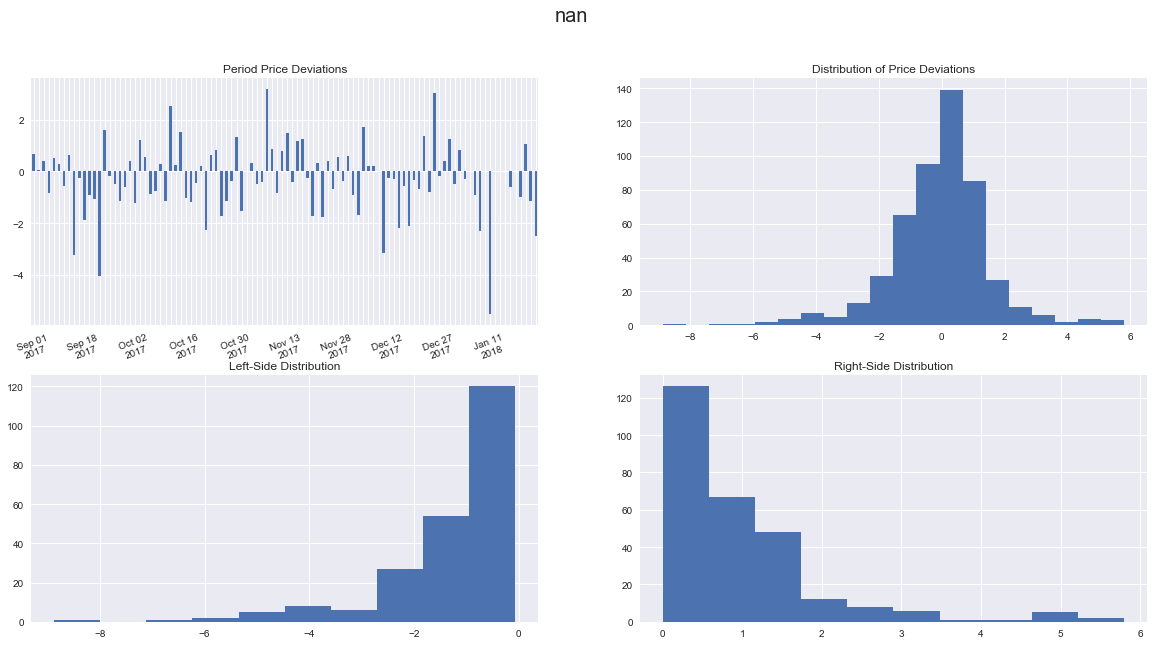

In [9]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [10]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,6.290000,AKS
1,191.869995,AET
2,92.830002,HCA
3,54.700001,HOG
4,175.660004,MCD
5,68.239998,NUE
6,343.109985,BA
7,50.349998,DHI
8,85.010002,LLY
9,29.110001,EPD


In [14]:
full_df['price_dev'].dropna().skew()

0.75157125093740373

In [15]:
full_df['price_dev'].dropna().describe()

count    2605.000000
mean        0.057219
std         1.819942
min       -11.782973
25%        -0.655835
50%         0.013202
75%         0.782285
max        24.518553
Name: price_dev, dtype: float64

In [28]:
std_thresh = 4

down_nums = summary[summary.index <= -std_thresh].sum()
up_nums = summary[summary.index >= std_thresh].sum()

print("Threshold stdev: {0} \nNumber of deviations downward: {1} \nNumber of deviations upward: {2}".format(std_thresh,
                                                                                                           down_nums,
                                                                                                           up_nums))

Threshold stdev: 4 
Number of deviations downward: Frequency    7
dtype: int64 
Number of deviations upward: Frequency    10
dtype: int64


In [16]:
full_df.to_csv('avgo.csv')